# Sieci neuronowe

## Wstęp

Celem laboratorium jest zapoznanie się z podstawami sieci neuronowych oraz uczeniem głębokim (*deep learning*). Zapoznasz się na nim z następującymi tematami:
- treningiem prostych sieci neuronowych, w szczególności z:
  - regresją liniową w sieciach neuronowych
  - optymalizacją funkcji kosztu
  - algorytmem spadku wzdłuż gradientu
  - siecią typu Multilayer Perceptron (MLP)
- frameworkiem PyTorch, w szczególności z:
  - ładowaniem danych
  - preprocessingiem danych
  - pisaniem pętli treningowej i walidacyjnej
  - walidacją modeli
- architekturą i hiperaprametrami sieci MLP, w szczególności z:
  - warstwami gęstymi (w pełni połączonymi)
  - funkcjami aktywacji
  - regularyzacją: L2, dropout

## Wykorzystywane biblioteki

Zaczniemy od pisania ręcznie prostych sieci w bibliotece Numpy, służącej do obliczeń numerycznych na CPU. Później przejdziemy do wykorzystywania frameworka PyTorch, służącego do obliczeń numerycznych na CPU, GPU oraz automatycznego różniczkowania, wykorzystywanego głównie do treningu sieci neuronowych.

Wykorzystamy PyTorcha ze względu na popularność, łatwość instalacji i użycia, oraz dużą kontrolę nad niskopoziomowymi aspektami budowy i treningu sieci neuronowych. Framework ten został stworzony do zastosowań badawczych i naukowych, ale ze względu na wygodę użycia stał się bardzo popularny także w przemyśle. W szczególności całkowicie zdominował przetwarzanie języka naturalnego (NLP) oraz uczenie na grafach.

Pierwszy duży framework do deep learningu, oraz obecnie najpopularniejszy, to TensorFlow, wraz z wysokopoziomową nakładką Keras. Są jednak szanse, że Google (autorzy) będzie go powoli porzucać na rzecz ich nowego frameworka JAX ([dyskusja](https://www.reddit.com/r/MachineLearning/comments/vfl57t/d_google_quietly_moving_its_products_from/), [artykuł Business Insidera](https://www.businessinsider.com/facebook-pytorch-beat-google-tensorflow-jax-meta-ai-2022-6?IR=T)), który jest bardzo świeżym, ale ciekawym narzędziem.

Trzecia, ale znacznie mniej popularna od powyższych opcja to Apache MXNet.

## Konfiguracja własnego komputera

Jeżeli korzystasz z własnego komputera, to musisz zainstalować trochę więcej bibliotek (Google Colab ma je już zainstalowane).

Jeżeli nie masz GPU lub nie chcesz z niego korzystać, to wystarczy znaleźć odpowiednią komendę CPU [na stronie PyTorcha](https://pytorch.org/get-started/locally/). Dla Anacondy odpowiednia komenda została podana poniżej, dla pip'a znajdź ją na stronie.

Jeżeli chcesz korzystać ze wsparcia GPU (na tym laboratorium nie będzie potrzebne, na kolejnych może przyspieszyć nieco obliczenia), to musi być to odpowiednio nowa karta NVidii, mająca CUDA compatibility ([lista](https://developer.nvidia.com/cuda-gpus)). Poza PyTorchem będzie potrzebne narzędzie NVidia CUDA w wersji 11.6 lub 11.7. Instalacja na Windowsie jest bardzo prosta (wystarczy ściągnąć plik EXE i zainstalować jak każdy inny program). Instalacja na Linuxie jest trudna i można względnie łatwo zepsuć sobie system, ale jeżeli chcesz spróbować, to [ten tutorial](https://www.youtube.com/results?search_query=nvidia+cuda+install+ubuntu+20.04) jest bardzo dobry.

# for conda users
!conda install -y matplotlib pandas pytorch torchvision -c pytorch -c conda-forge

!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

## Wprowadzenie

Zanim zaczniemy naszą przygodę z sieciami neuronowymi, przyjrzyjmy się prostemu przykładowi regresji liniowej na syntetycznych danych:

In [2]:
from typing import Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

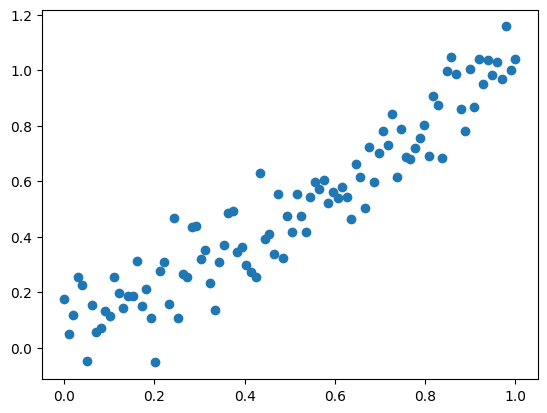

In [3]:
np.random.seed(0)

x = np.linspace(0, 1, 100)
y = x + np.random.normal(scale=0.1, size=x.shape)

plt.scatter(x, y)

W przeciwieństwie do laboratorium 1, tym razem będziemy chcieli rozwiązać ten problem własnoręcznie, bez użycia wysokopoziomowego interfejsu Scikit-learn'a. W tym celu musimy sobie przypomnieć sformułowanie naszego **problemu optymalizacyjnego (optimization problem)**.

W przypadku prostej regresji liniowej (1 zmienna) mamy model postaci $\hat{y} = \alpha x + \beta$, z dwoma parametrami, których będziemy się uczyć. Miarą niedopasowania modelu o danych parametrach jest **funkcja kosztu (cost function)**, nazywana też funkcją celu. Najczęściej używa się **błędu średniokwadratowego (mean squared error, MSE)**:
$$\large
MSE = \frac{1}{N} \sum_{i}^{N} (y - \hat{y})^2
$$

Od jakich $\alpha$ i $\beta$ zacząć? W najprostszym wypadku wystarczy po prostu je wylosować jako niewielkie liczby zmiennoprzecinkowe.

#### Zadanie 1 (0.5 punkt)

Uzupełnij kod funkcji `mse`, obliczającej błąd średniokwadratowy. Wykorzystaj Numpy'a w celu wektoryzacji obliczeń dla wydajności.

In [4]:
def mse(y: np.ndarray, y_hat: np.ndarray) -> float:
    return np.sum((y - y_hat) ** 2) / len(y)

MSE: 0.133


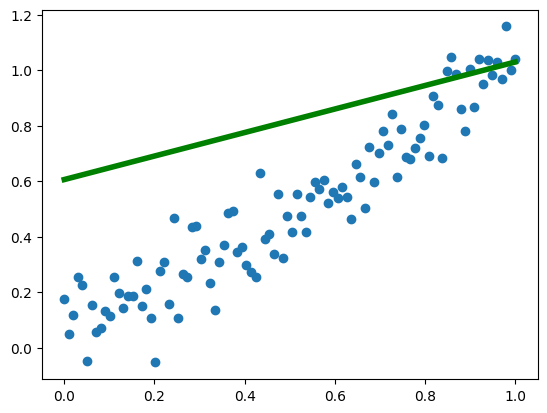

In [5]:
a = np.random.rand()
b = np.random.rand()
print(f"MSE: {mse(y, a * x + b):.3f}")

plt.scatter(x, y)
plt.plot(x, a * x + b, color="g", linewidth=4)

Losowe parametry radzą sobie nie najlepiej. Jak lepiej dopasować naszą prostą do danych? Zawsze możemy starać się wyprowadzić rozwiązanie analitycznie, i w tym wypadku nawet nam się uda. Jest to jednak szczególny i dość rzadki przypadek, a w szczególności nie będzie to możliwe w większych sieciach neuronowych.

Potrzebna nam będzie **metoda optymalizacji (optimization method)**, dającą wartości parametrów minimalizujące dowolną różniczkowalną funkcję kosztu. Zdecydowanie najpopularniejszy jest tutaj **spadek wzdłuż gradientu (gradient descent)**.

Metoda ta wywodzi się z prostych obserwacji, które tutaj przedstawimy. Bardziej szczegółowe rozwinięcie dla zainteresowanych: [sekcja 4.3 "Deep Learning Book"](https://www.deeplearningbook.org/contents/numerical.html), [ten praktyczny kurs](https://cs231n.github.io/optimization-1/), [analiza oryginalnej publikacji Cauchy'ego](https://www.math.uni-bielefeld.de/documenta/vol-ismp/40_lemarechal-claude.pdf) (oryginał w języku francuskim).

Pochodna jest dokładnie równa granicy funkcji. Dla małego $\epsilon$ można ją przybliżyć jako:
$$\large
\frac{f(x)}{dx} \approx \frac{f(x+\epsilon) - f(x)}{\epsilon}
$$

Przyglądając się temu równaniu widzimy, że: 
* dla funkcji rosnącej ($f(x+\epsilon) > f(x)$) wyrażenie $\frac{f(x)}{dx}$ będzie miało znak dodatni 
* dla funkcji malejącej ($f(x+\epsilon) < f(x)$) wyrażenie $\frac{f(x)}{dx}$ będzie miało znak ujemny 

Widzimy więc, że potrafimy wskazać kierunek zmniejszenia wartości funkcji, patrząc na znak pochodnej. Zaobserwowano także, że amplituda wartości w $\frac{f(x)}{dx}$ jest tym większa, im dalej jesteśmy od minimum (maximum). Pochodna wyznacza więc, w jakim kierunku funkcja najszybciej rośnie, zaś przeciwny zwrot to ten, w którym funkcja najszybciej spada.

Stosując powyższe do optymalizacji, mamy:
$$\large
x_{t+1} = x_{t} -  \alpha * \frac{f(x)}{dx}
$$

$\alpha$ to niewielka wartość (rzędu zwykle $10^{-5}$ - $10^{-2}$), wprowadzona, aby trzymać się założenia o małej zmianie parametrów ($\epsilon$). Nazywa się ją **stałą uczącą (learning rate)** i jest zwykle najważniejszym hiperparametrem podczas nauki sieci.

Metoda ta zakłada, że używamy całego zbioru danych do aktualizacji parametrów w każdym kroku, co nazywa się po prostu GD (od *gradient descent*) albo *full batch GD*. Wtedy każdy krok optymalizacji nazywa się **epoką (epoch)**.

Im większa stała ucząca, tym większe nasze kroki podczas minimalizacji. Możemy więc uczyć szybciej, ale istnieje ryzyko, że będziemy "przeskakiwać" minima. Mniejsza stała ucząca to wolniejszy, ale dokładniejszy trening. Jednak nie zawsze ona pozwala osiągnąć lepsze wyniki, bo może okazać się, że utkniemy w minimum lokalnym. Można także zmieniać stałą uczącą podczas treningu, co nazywa się **learning rate scheduling (LR scheduling)**. Obrazowo:

![learning_rate](http://www.bdhammel.com/assets/learning-rate/lr-types.png)

![interactive LR](http://cdn-images-1.medium.com/max/640/1*eeIvlwkMNG1wSmj3FR6M2g.gif)

Policzmy więc pochodną dla naszej funkcji kosztu MSE. Pochodną liczymy po parametrach naszego modelu, bo to właśnie ich chcemy dopasować tak, żeby koszt był jak najmniejszy:

$$\large
MSE = \frac{1}{N} \sum_{i}^{N} (y_i - \hat{y_i})^2
$$

W powyższym wzorze tylko $y_i$ jest zależny od $a$ oraz $b$. Możemy wykorzystać tu regułę łańcuchową (*chain rule*) i policzyć pochodne po naszych parametrach w sposób następujący:

$$\large
\frac{\text{d} MSE}{\text{d} a} = \frac{1}{N} \sum_{i}^{N} \frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} \frac{\text{d} \hat{y_i}}{\text{d} a}
$$

$$\large
\frac{\text{d} MSE}{\text{d} b} = \frac{1}{N} \sum_{i}^{N} \frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} \frac{\text{d} \hat{y_i}}{\text{d} b}
$$

Policzmy te pochodne po kolei:

$$\large
\frac{\text{d} (y_i - \hat{y_i})^2}{\text{d} \hat{y_i}} = -2 \cdot (y_i - \hat{y_i})
$$

$$\large
\frac{\text{d} \hat{y_i}}{\text{d} a} = x_i
$$

$$\large
\frac{\text{d} \hat{y_i}}{\text{d} b} = 1
$$

Łącząc powyższe wyniki dostaniemy:

$$\large
\frac{\text{d} MSE}{\text{d} a} = \frac{-2}{N} \sum_{i}^{N} (y_i - \hat{y_i}) \cdot {x_i}
$$

$$\large
\frac{\text{d} MSE}{\text{d} b} = \frac{-2}{N} \sum_{i}^{N} (y_i - \hat{y_i})
$$

Aktualizacja parametrów wygląda tak:

$$\large
a' = a - \alpha * \left( \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i) \cdot x_i \right)
$$
$$\large
b' = b - \alpha * \left( \frac{-2}{N} \sum_{i=1}^N (y_i - \hat{y}_i) \right)
$$

Liczymy więc pochodną funkcji kosztu, a potem za pomocą reguły łańcuchowej "cofamy się", dochodząc do tego, jak każdy z parametrów wpływa na błąd i w jaki sposób powinniśmy go zmienić. Nazywa się to **propagacją wsteczną (backpropagation)** i jest podstawowym mechanizmem umożliwiającym naukę sieci neuronowych za pomocą spadku wzdłuż gradientu. Więcej możesz o tym przeczytać [tutaj](https://cs231n.github.io/optimization-2/).


#### Zadanie 2 (1.0 punkt)

Zaimplementuj funkcję realizującą jedną epokę treningową. Zauważ, że `x` oraz `y` są wektorami. Oblicz predykcję przy aktualnych parametrach oraz zaktualizuj je zgodnie z powyższymi wzorami.

In [6]:
def optimize(
    x: np.ndarray, y: np.ndarray, a: float, b: float, learning_rate: float = 0.1
):
    y_hat = a * x + b
    errors = y - y_hat
    n = len(x)

    a = a - learning_rate * ( -2 / n) * np.sum(errors * x)
    b = b - learning_rate * (-2 / n) * np.sum(errors)

    return (a, b)


In [7]:
for i in range(1000):
    loss = mse(y, a * x + b)
    a, b = optimize(x, y, a, b)
    if i % 100 == 0:
        print(f"step {i} loss: ", loss)

print("final loss:", loss)

step 0 loss:  0.1330225119404028
step 100 loss:  0.012673197778527677
step 200 loss:  0.010257153540857817
step 300 loss:  0.0100948037549359
step 400 loss:  0.010083894412889118
step 500 loss:  0.010083161342973332
step 600 loss:  0.010083112083219709
step 700 loss:  0.010083108773135261
step 800 loss:  0.010083108550709076
step 900 loss:  0.01008310853576281
final loss: 0.010083108534760455


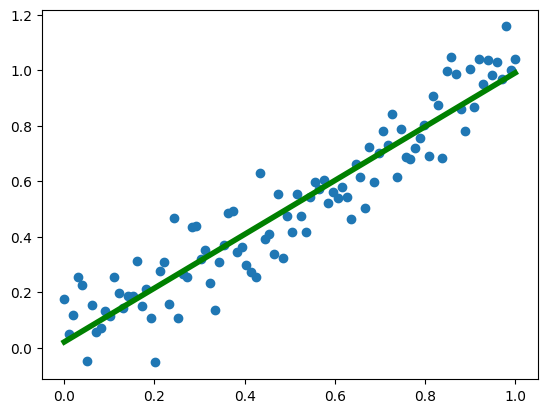

In [8]:
plt.scatter(x, y)
plt.plot(x, a * x + b, color="g", linewidth=4)

Udało ci się wytrenować swoją pierwszą sieć neuronową. Czemu? Otóż neuron to po prostu wektor parametrów, a zwykle robimy iloczyn skalarny tych parametrów z wejściem. Dodatkowo na wyjście nakłada się **funkcję aktywacji (activation function)**, która przekształca wyjście. Tutaj takiej nie było, a właściwie była to po prostu funkcja identyczności.

Oczywiście w praktyce korzystamy z odpowiedniego frameworka, który w szczególności:
- ułatwia budowanie sieci, np. ma gotowe klasy dla warstw neuronów
- ma zaimplementowane funkcje kosztu oraz ich pochodne
- sam różniczkuje ze względu na odpowiednie parametry i aktualizuje je odpowiednio podczas treningu


## Wprowadzenie do PyTorcha

PyTorch to w gruncie rzeczy narzędzie do algebry liniowej z [automatycznym rożniczkowaniem](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html), z możliwością przyspieszenia obliczeń z pomocą GPU. Na tych fundamentach zbudowany jest pełny framework do uczenia głębokiego. Można spotkać się ze stwierdzenie, że PyTorch to NumPy + GPU + opcjonalne różniczkowanie, co jest całkiem celne. Plus można łatwo debugować printem :)

PyTorch używa dynamicznego grafu obliczeń, który sami definiujemy w kodzie. Takie podejście jest bardzo wygodne, elastyczne i pozwala na łatwe eksperymentowanie. Odbywa się to potencjalnie kosztem wydajności, ponieważ pozostawia kwestię optymalizacji programiście. Więcej na ten temat dla zainteresowanych na końcu laboratorium.

Samo API PyTorcha bardzo przypomina Numpy'a, a podstawowym obiektem jest `Tensor`, klasa reprezentująca tensory dowolnego wymiaru. Dodatkowo niektóre tensory będą miały automatycznie obliczony gradient. Co ważne, tensor jest na pewnym urządzeniu, CPU lub GPU, a przenosić między nimi trzeba explicite.

Najważniejsze moduły:
- `torch` - podstawowe klasy oraz funkcje, np. `Tensor`, `from_numpy()`
- `torch.nn` - klasy związane z sieciami neuronowymi, np. `Linear`, `Sigmoid`
- `torch.optim` - wszystko związane z optymalizacją, głównie spadkiem wzdłuż gradientu

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
ones = torch.ones(10)
noise = torch.ones(10) * torch.rand(10)

# elementwise sum
print(ones + noise)

# elementwise multiplication
print(ones * noise)

# dot product
print(ones @ noise)

tensor([1.4154, 1.8855, 1.2668, 1.9454, 1.3595, 1.6473, 1.9778, 1.1298, 1.7165,
        1.4596])
tensor([0.4154, 0.8855, 0.2668, 0.9454, 0.3595, 0.6473, 0.9778, 0.1298, 0.7165,
        0.4596])
tensor(5.8036)


In [11]:
_x, _y = x, y

In [12]:
# beware - shares memory with original Numpy array!
# very fast, but modifications are visible to original variable
x = torch.from_numpy(_x)
y = torch.from_numpy(_y)

Jeżeli dla stworzonych przez nas tensorów chcemy śledzić operacje i obliczać gradient, to musimy oznaczyć `requires_grad=True`.

In [13]:
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
a, b

(tensor([0.0464], requires_grad=True), tensor([0.8258], requires_grad=True))

PyTorch zawiera większość powszechnie używanych funkcji kosztu, np. MSE. Mogą być one używane na 2 sposoby, z czego pierwszy jest popularniejszy:
- jako klasy wywoływalne z modułu `torch.nn`
- jako funkcje z modułu `torch.nn.functional`

Po wykonaniu poniższego kodu widzimy, że zwraca on nam tensor z dodatkowymi atrybutami. Co ważne, jest to skalar (0-wymiarowy tensor), bo potrzebujemy zwyczajnej liczby do obliczania propagacji wstecznych (pochodnych czątkowych).

In [14]:
mse = nn.MSELoss()
mse(y, a * x + b)

tensor(0.2003, dtype=torch.float64, grad_fn=<MseLossBackward0>)

Atrybutu `grad_fn` nie używamy wprost, bo korzysta z niego w środku PyTorch, ale widać, że tensor jest "świadomy", że liczy się na nim pochodną. Możemy natomiast skorzystać z atrybutu `grad`, który zawiera faktyczny gradient. Zanim go jednak dostaniemy, to trzeba powiedzieć PyTorchowi, żeby policzył gradient. Służy do tego metoda `.backward()`, wywoływana na obiekcie zwracanym przez funkcję kosztu.

In [15]:
loss = mse(y, a * x + b)
loss.backward()

In [16]:
print(a.grad)

tensor([0.1860])


Ważne jest, że PyTorch nie liczy za każdym razem nowego gradientu, tylko dodaje go do istniejącego, czyli go akumuluje. Jest to przydatne w niektórych sieciach neuronowych, ale zazwyczaj trzeba go zerować. Jeżeli tego nie zrobimy, to dostaniemy coraz większe gradienty.

Do zerowania służy metoda `.zero_()`. W PyTorchu wszystkie metody modyfikujące tensor w miejscu mają `_` na końcu nazwy. Jest to dość niskopoziomowa operacja dla pojedynczych tensorów - zobaczymy za chwilę, jak to robić łatwiej dla całej sieci.

In [17]:
loss = mse(y, a * x + b)
loss.backward()
a.grad

tensor([0.3720])

Zobaczmy, jak wyglądałaby regresja liniowa, ale napisana w PyTorchu. Jest to oczywiście bardzo niskopoziomowa implementacja - za chwilę zobaczymy, jak to wygląda w praktyce.

In [18]:
learning_rate = 0.1
for i in range(1000):
    loss = mse(y, a * x + b)

    # compute gradients
    loss.backward()

    # update parameters
    a.data -= learning_rate * a.grad
    b.data -= learning_rate * b.grad

    # zero gradients
    a.grad.data.zero_()
    b.grad.data.zero_()

    if i % 100 == 0:
        print(f"step {i} loss: ", loss)

print("final loss:", loss)

step 0 loss:  tensor(0.2003, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 100 loss:  tensor(0.0162, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 200 loss:  tensor(0.0105, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 300 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 400 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 500 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 600 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 700 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 800 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
step 900 loss:  tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)
final loss: tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)


Trening modeli w PyTorchu jest dosyć schematyczny i najczęściej rozdziela się go na kilka bloków, dających razem **pętlę uczącą (training loop)**, powtarzaną w każdej epoce:
1. Forward pass - obliczenie predykcji sieci
2. Loss calculation
3. Backpropagation - obliczenie pochodnych oraz zerowanie gradientów
4. Optimalization - aktualizacja wag
5. Other - ewaluacja na zbiorze walidacyjnym, logging etc.

In [19]:
# initialization
learning_rate = 0.1
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
optimizer = torch.optim.SGD([a, b], lr=learning_rate)
best_loss = float("inf")

# training loop in each epoch
for i in range(1000):
    # forward pass
    y_hat = a * x + b

    # loss calculation
    loss = mse(y, y_hat)

    # backpropagation
    loss.backward()

    # optimization
    optimizer.step()
    optimizer.zero_grad()  # zeroes all gradients - very convenient!

    if i % 100 == 0:
        if loss < best_loss:
            best_model = (a.clone(), b.clone())
            best_loss = loss
        print(f"step {i} loss: {loss.item():.4f}")

print("final loss:", loss)

step 0 loss: 0.4044
step 100 loss: 0.0122
step 200 loss: 0.0102
step 300 loss: 0.0101
step 400 loss: 0.0101
step 500 loss: 0.0101
step 600 loss: 0.0101
step 700 loss: 0.0101
step 800 loss: 0.0101
step 900 loss: 0.0101
final loss: tensor(0.0101, dtype=torch.float64, grad_fn=<MseLossBackward0>)


Przejdziemy teraz do budowy sieci neuronowej do klasyfikacji. Typowo implementuje się ją po prostu jako sieć dla regresji, ale zwracającą tyle wyników, ile mamy klas, a potem aplikuje się na tym funkcję sigmoidalną (2 klasy) lub softmax (>2 klasy). W przypadku klasyfikacji binarnej zwraca się czasem tylko 1 wartość, przepuszczaną przez sigmoidę - wtedy wyjście z sieci to prawdopodobieństwo klasy pozytywnej.

Funkcją kosztu zwykle jest **entropia krzyżowa (cross-entropy)**, stosowana też w klasycznej regresji logistycznej. Co ważne, sieci neuronowe, nawet tak proste, uczą się szybciej i stabilniej, gdy dane na wejściu (a przynajmniej zmienne numeryczne) są **ustandaryzowane (standardized)**. Operacja ta polega na odjęciu średniej i podzieleniu przez odchylenie standardowe (tzw. *Z-score transformation*).

**Uwaga - PyTorch wymaga tensora klas będącego liczbami zmiennoprzecinkowymi!**

## Zbiór danych

Na tym laboratorium wykorzystamy zbiór [Adult Census](https://archive.ics.uci.edu/ml/datasets/adult). Dotyczy on przewidywania na podstawie danych demograficznych, czy dany człowiek zarabia powyżej 50 tysięcy dolarów rocznie, czy też mniej. Jest to cenna informacja np. przy planowaniu kampanii marketingowych. Jak możesz się domyślić, zbiór pochodzi z czasów, kiedy inflacja była dużo niższa :)

Poniżej znajduje się kod do ściągnięcia i preprocessingu zbioru. Nie musisz go dokładnie analizować.

In [20]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-25 22:56:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: 'adult.data.1'

     0K .......... .......... .......... .......... ..........  145K
    50K .......... .......... .......... .......... ..........  546K
   100K .......... .......... .......... .......... ..........  591K
   150K .......... .......... .......... .......... .......... 15,5M
   200K .......... .......... .......... .......... ..........  293K
   250K .......... .......... .......... .......... .......... 16,8M
   300K .......... .......... .......... .......... ..........  598K
   350K .......... .......... .......... .......... .......... 15,2M
   400K .......... .......... .......... .......... .......... 22,5M
   450K .......... ......

In [21]:
import pandas as pd


columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "wage"
]

"""
age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.f
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
"""

df = pd.read_csv("adult.data", header=None, names=columns)
df.wage.unique()

array([' <=50K', ' >50K'], dtype=object)

In [22]:
# attribution: https://www.kaggle.com/code/royshih23/topic7-classification-in-python
df['education'].replace('Preschool', 'dropout',inplace=True)
df['education'].replace('10th', 'dropout',inplace=True)
df['education'].replace('11th', 'dropout',inplace=True)
df['education'].replace('12th', 'dropout',inplace=True)
df['education'].replace('1st-4th', 'dropout',inplace=True)
df['education'].replace('5th-6th', 'dropout',inplace=True)
df['education'].replace('7th-8th', 'dropout',inplace=True)
df['education'].replace('9th', 'dropout',inplace=True)
df['education'].replace('HS-Grad', 'HighGrad',inplace=True)
df['education'].replace('HS-grad', 'HighGrad',inplace=True)
df['education'].replace('Some-college', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
df['education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
df['education'].replace('Bachelors', 'Bachelors',inplace=True)
df['education'].replace('Masters', 'Masters',inplace=True)
df['education'].replace('Prof-school', 'Masters',inplace=True)
df['education'].replace('Doctorate', 'Doctorate',inplace=True)

df['marital-status'].replace('Never-married', 'NotMarried',inplace=True)
df['marital-status'].replace(['Married-AF-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-civ-spouse'], 'Married',inplace=True)
df['marital-status'].replace(['Married-spouse-absent'], 'NotMarried',inplace=True)
df['marital-status'].replace(['Separated'], 'Separated',inplace=True)
df['marital-status'].replace(['Divorced'], 'Separated',inplace=True)
df['marital-status'].replace(['Widowed'], 'Widowed',inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler


X = df.copy()
y = (X.pop("wage") == ' >50K').astype(int).values

train_valid_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, 
    test_size=train_valid_size, 
    random_state=0, 
    shuffle=True, 
    stratify=y_train
)

continuous_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
continuous_X_train = X_train[continuous_cols]
categorical_X_train = X_train.loc[:, ~X_train.columns.isin(continuous_cols)]

continuous_X_valid = X_valid[continuous_cols]
categorical_X_valid = X_valid.loc[:, ~X_valid.columns.isin(continuous_cols)]

continuous_X_test = X_test[continuous_cols]
categorical_X_test = X_test.loc[:, ~X_test.columns.isin(continuous_cols)]

categorical_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
continuous_scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))

categorical_encoder.fit(categorical_X_train)
continuous_scaler.fit(continuous_X_train)

continuous_X_train = continuous_scaler.transform(continuous_X_train)
continuous_X_valid = continuous_scaler.transform(continuous_X_valid)
continuous_X_test = continuous_scaler.transform(continuous_X_test)

categorical_X_train = categorical_encoder.transform(categorical_X_train)
categorical_X_valid = categorical_encoder.transform(categorical_X_valid)
categorical_X_test = categorical_encoder.transform(categorical_X_test)

X_train = np.concatenate([continuous_X_train, categorical_X_train], axis=1)
X_valid = np.concatenate([continuous_X_valid, categorical_X_valid], axis=1)
X_test = np.concatenate([continuous_X_test, categorical_X_test], axis=1)

In [171]:
X_train.shape, y_train.shape

(torch.Size([20838, 108]), torch.Size([20838, 1]))

Uwaga co do typów - PyTorchu wszystko w sieci neuronowej musi być typu `float32`. W szczególności trzeba uważać na konwersje z Numpy'a, który używa domyślnie typu `float64`. Może ci się przydać metoda `.float()`.

Uwaga co do kształtów wyjścia - wejścia do `nn.BCELoss` muszą być tego samego kształtu. Może ci się przydać metoda `.squeeze()` lub `.unsqueeze()`.

In [24]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(-1)

X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float().unsqueeze(-1)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(-1)

Podobnie jak w laboratorium 2, mamy tu do czynienia z klasyfikacją niezbalansowaną:

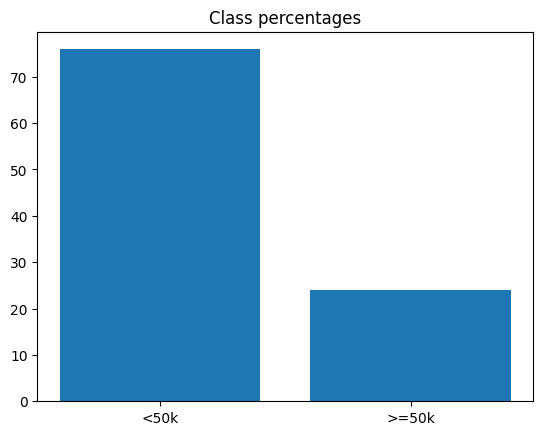

In [25]:
import matplotlib.pyplot as plt

y_pos_perc = 100 * y_train.sum().item() / len(y_train)
y_neg_perc = 100 - y_pos_perc

plt.title("Class percentages")
plt.bar(["<50k", ">=50k"], [y_neg_perc, y_pos_perc])
plt.show()

W związku z powyższym będziemy używać odpowiednich metryk, czyli AUROC, precyzji i czułości.

#### Zadanie 3 (1.0 punkt)

Zaimplementuj regresję logistyczną dla tego zbioru danych, używając PyTorcha. Dane wejściowe zostały dla ciebie przygotowane w komórkach poniżej.

Sama sieć składa się z 2 elementów:
- warstwa liniowa `nn.Linear`, przekształcająca wektor wejściowy na 1 wyjście - logit
- aktywacja sigmoidalna `nn.Sigmoid`, przekształcająca logit na prawdopodobieństwo klasy pozytywnej

Użyj binarnej entropii krzyżowej `nn.BCELoss` jako funkcji kosztu. Użyj optymalizatora SGD ze stałą uczącą `1e-3`. Trenuj przez 3000 epok. Pamiętaj, aby przekazać do optymalizatora `torch.optim.SGD` parametry sieci (metoda `.parameters()`). Dopisz logowanie kosztu raz na 100 epok.

In [174]:
learning_rate = 1e-3

input_size = X_train.shape[1]

model = nn.Linear(input_size, 1)
activation = nn.Sigmoid()
optimizer = optim.SGD(lr=learning_rate, params=model.parameters())
loss_fn = nn.BCELoss()

epochs = 3000

best_loss = float('inf')

model.train()

for epoch in range(1, epochs + 1):
    outputs = activation(model(X_train))
    loss = loss_fn(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if best_loss > loss:
        best_loss = loss

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}/{epochs}\tLoss: {loss.item()}")

print(f"Best loss: {best_loss.item()}")

Epoch: 100/3000	Loss: 0.6276997923851013


Epoch: 200/3000	Loss: 0.6031697392463684
Epoch: 300/3000	Loss: 0.5826571583747864
Epoch: 400/3000	Loss: 0.5653572082519531
Epoch: 500/3000	Loss: 0.5506343245506287
Epoch: 600/3000	Loss: 0.5379889011383057
Epoch: 700/3000	Loss: 0.5270274877548218
Epoch: 800/3000	Loss: 0.5174400806427002
Epoch: 900/3000	Loss: 0.508981466293335
Epoch: 1000/3000	Loss: 0.5014569759368896
Epoch: 1100/3000	Loss: 0.4947112500667572
Epoch: 1200/3000	Loss: 0.48861974477767944
Epoch: 1300/3000	Loss: 0.483082115650177
Epoch: 1400/3000	Loss: 0.47801676392555237
Epoch: 1500/3000	Loss: 0.4733572006225586
Epoch: 1600/3000	Loss: 0.4690491259098053
Epoch: 1700/3000	Loss: 0.46504727005958557
Epoch: 1800/3000	Loss: 0.46131429076194763
Epoch: 1900/3000	Loss: 0.4578188955783844
Epoch: 2000/3000	Loss: 0.4545348584651947
Epoch: 2100/3000	Loss: 0.45143988728523254
Epoch: 2200/3000	Loss: 0.4485150873661041
Epoch: 2300/3000	Loss: 0.44574421644210815
Epoch: 2400/3000	Loss: 0.4431132972240448
Epoch: 2500/3000	Loss: 0.4406102001667

Teraz trzeba sprawdzić, jak poszło naszej sieci. W PyTorchu sieć pracuje zawsze w jednym z dwóch trybów: treningowym lub ewaluacyjnym (predykcyjnym). Ten drugi wyłącza niektóre mechanizmy, które są używane tylko podczas treningu, w szczególności regularyzację dropout. Do przełączania służą metody modelu `.train()` i `.eval()`.

Dodatkowo podczas liczenia predykcji dobrze jest wyłączyć liczenie gradientów, bo nie będą potrzebne, a oszczędza to czas i pamięć. Używa się do tego menadżera kontekstu `with torch.no_grad():`.

In [175]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, roc_auc_score

model.eval()
with torch.no_grad():
    y_score = activation(model(X_test))

auroc = roc_auc_score(y_test, y_score)
print(f"AUROC: {100 * auroc:.2f}%")

AUROC: 86.04%


Jest to całkiem dobry wynik, a może być jeszcze lepszy. Sprawdźmy dla pewności jeszcze inne metryki: precyzję, recall oraz F1-score. Dodatkowo narysujemy krzywą precision-recall, czyli jak zmieniają się te metryki w zależności od przyjętego progu (threshold) prawdopodobieństwa, powyżej którego przyjmujemy klasę pozytywną. Taką krzywą należy rysować na zbiorze walidacyjnym, bo później chcemy wykorzystać tę informację do doboru progu, a nie chcemy mieć wycieku danych testowych (data leakage).

Poniżej zaimplementowano także funkcję `get_optimal_threshold()`, która sprawdza, dla którego progu uzyskujemy maksymalny F1-score, i zwraca indeks oraz wartość optymalnego progu. Przyda ci się ona w dalszej części laboratorium.

In [57]:
from sklearn.metrics import PrecisionRecallDisplay


def get_optimal_threshold(
    precisions: np.array, 
    recalls: np.array, 
    thresholds: np.array
) -> Tuple[int, float]:
    
    numerator = 2 * precisions * recalls
    denominator = precisions + recalls
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_idx, optimal_threshold


def plot_precision_recall_curve(y_true, y_pred_score) -> None:
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_score)
    optimal_idx, optimal_threshold = get_optimal_threshold(precisions, recalls, thresholds)

    disp = PrecisionRecallDisplay(precisions, recalls)
    disp.plot()
    plt.title(f"Precision-recall curve (opt. thresh.: {optimal_threshold:.4f})")
    plt.axvline(recalls[optimal_idx], color="green", linestyle="-.")
    plt.axhline(precisions[optimal_idx], color="green", linestyle="-.")
    plt.show()


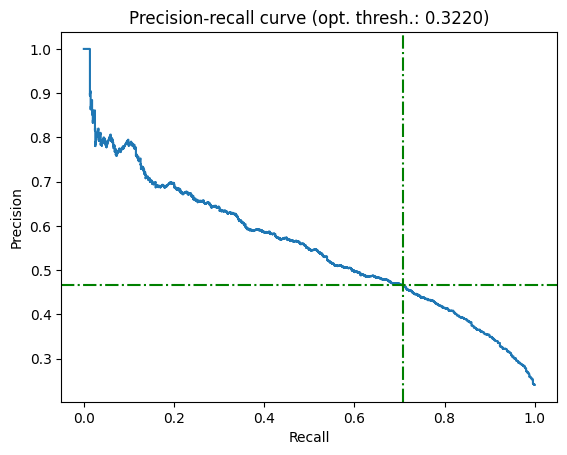

In [58]:
model.eval()
with torch.no_grad():
    y_pred_valid_score = activation(model(X_valid))

plot_precision_recall_curve(y_valid, y_pred_valid_score)

Jak widać, chociaż AUROC jest wysokie, to dla optymalnego F1-score recall nie jest zbyt wysoki, a precyzja jest już dość niska. Być może wynik uda się poprawić, używając modelu o większej pojemności - pełnej, głębokiej sieci neuronowej.

## Sieci neuronowe

Wszystko zaczęło się od inspirowanych biologią [sztucznych neuronów](https://en.wikipedia.org/wiki/Artificial_neuron), których próbowano użyć do symulacji mózgu. Naukowcy szybko odeszli od tego podejścia (sam problem modelowania okazał się też znacznie trudniejszy, niż sądzono), zamiast tego używając neuronów jako jednostek reprezentującą dowolną funkcję parametryczną $f(x, \Theta)$. Każdy neuron jest zatem bardzo elastyczny, bo jedyne wymagania to funkcja różniczkowalna, a mamy do tego wektor parametrów $\Theta$.

W praktyce najczęściej można spotkać się z kilkoma rodzinami sieci neuronowych:
1. Perceptrony wielowarstwowe (*MultiLayer Perceptron*, MLP) - najbardziej podobne do powyższego opisu, niezbędne do klasyfikacji i regresji
2. Konwolucyjne (*Convolutional Neural Networks*, CNNs) - do przetwarzania danych z zależnościami przestrzennymi, np. obrazów czy dźwięku
3. Rekurencyjne (*Recurrent Neural Networks*, RNNs) - do przetwarzania danych z zależnościami sekwencyjnymi, np. szeregi czasowe, oraz kiedyś do języka naturalnego
4. Transformacyjne (*Transformers*), oparte o mechanizm atencji (*attention*) - do przetwarzania języka naturalnego (NLP), z którego wyparły RNNs, a coraz częściej także do wszelkich innych danych, np. obrazów, dźwięku
5. Grafowe (*Graph Neural Networks*, GNNS) - do przetwarzania grafów

Na tym laboratorium skupimy się na najprostszej architekturze, czyli MLP. Jest ona powszechnie łączona z wszelkimi innymi architekturami, bo pozwala dokonywać klasyfikacji i regresji. Przykładowo, klasyfikacja obrazów to zwykle CNN + MLP, klasyfikacja tekstów to transformer + MLP, a regresja na grafach to GNN + MLP.

Dodatkowo, pomimo prostoty MLP są bardzo potężne - udowodniono, że perceptrony (ich powszechna nazwa) są [uniwersalnym aproksymatorem](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208), będącym w stanie przybliżyć dowolną funkcję z odpowiednio małym błędem, zakładając wystarczającą wielkość warstw sieci. Szczególne ich wersje potrafią nawet [reprezentować drzewa decyzyjne](https://www.youtube.com/watch?v=_okxGdHM5b8).

Dla zainteresowanych polecamy [doskonałą książkę "Dive into Deep Learning", z implementacjami w PyTorchu](https://d2l.ai/chapter_multilayer-perceptrons/index.html), [klasyczną książkę "Deep Learning Book"](https://www.deeplearningbook.org/contents/mlp.html), oraz [ten filmik](https://www.youtube.com/watch?v=BFHrIxKcLjA), jeśli zastanawiałeś/-aś się, czemu używamy deep learning, a nie naprzykład (wide?) learning. (aka. czemu staramy się budować głębokie sieci, a nie płytkie za to szerokie)

### Sieci MLP

Dla przypomnienia, na wejściu mamy punkty ze zbioru treningowego, czyli $d$-wymiarowe wektory. W klasyfikacji chcemy znaleźć granicę decyzyjną, czyli krzywą, która oddzieli od siebie klasy. W wejściowej przestrzeni może być to trudne, bo chmury punktów z poszczególnych klas mogą być ze sobą dość pomieszane. Pamiętajmy też, że regresja logistyczna jest klasyfikatorem liniowym, czyli w danej przestrzeni potrafi oddzielić punkty tylko linią prostą.

Sieć MLP składa się z warstw. Każda z nich dokonuje nieliniowego przekształcenia przestrzeni (można o tym myśleć jak o składaniu przestrzeni jakąś prostą/łamaną), tak, aby w finalnej przestrzeni nasze punkty były możliwie liniowo separowalne. Wtedy ostatnia warstwa z sigmoidą będzie potrafiła je rozdzielić od siebie.

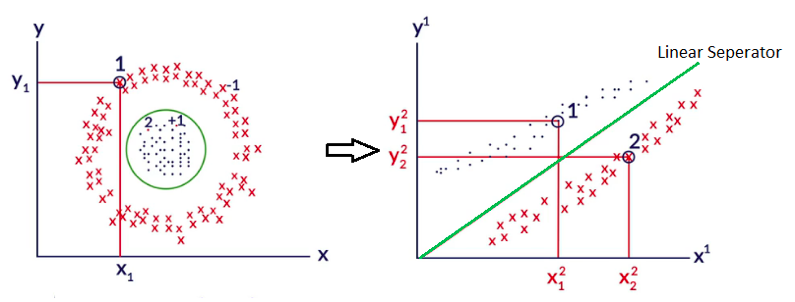

Poszczególne neurony składają się z iloczynu skalarnego wejść z wagami neuronu, oraz nieliniowej funkcji aktywacji. W PyTorchu są to osobne obiekty - `nn.Linear` oraz np. `nn.Sigmoid`. Funkcja aktywacji przyjmuje wynik iloczynu skalarnego i przekształca go, aby sprawdzić, jak mocno reaguje neuron na dane wejście. Musi być nieliniowa z dwóch powodów. Po pierwsze, tylko nieliniowe przekształcenia są na tyle potężne, żeby umożliwić liniową separację danych w ostatniej warstwie. Po drugie, liniowe przekształcenia zwyczajnie nie działają. Aby zrozumieć czemu, trzeba zobaczyć, co matematycznie oznacza sieć MLP.

![perceptron](https://www.saedsayad.com/images/Perceptron_bkp_1.png)

Zapisane matematycznie MLP to:

$\large
h_1 = f_1(x) \\
h_2 = f_2(h_1) \\
h_3 = f_3(h_2) \\
... \\
h_n = f_n(h_{n-1})
$

gdzie $x$ to wejście $f_i$ to funkcja aktywacji $i$-tej warstwy, a $h_i$ to wyjście $i$-tej warstwy, nazywane **ukrytą reprezentacją (hidden representation)**, lub *latent representation*. Nazwa bierze się z tego, że w środku sieci wyciągamy cechy i wzorce w danych, które nie są widoczne na pierwszy rzut oka na wejściu.

Załóżmy, że uczymy się na danych $x$ o jednym wymiarze (dla uproszczenia wzorów) oraz nie mamy funkcji aktywacji, czyli wykorzystujemy tak naprawdę aktywację liniową $f(x) = x$. Zobaczmy jak będą wyglądać dane przechodząc przez kolejne warstwy:

$\large
h_1 = f_1(xw_1) = xw_1 \\
h_2 = f_2(h_1w_2) = xw_1w_2 \\
... \\
h_n = f_n(h_{n-1}w_n) = xw_1w_2...w_n
$

gdzie $w_i$ to jest parametr $i$-tej warstwy sieci, $x$ to są dane (w naszym przypadku jedna liczba) wejściowa, a $h_i$ to wyjście $i$-tej warstwy.

Jak widać, taka sieć o $n$ warstwach jest równoważna sieci o jednej warstwie z parametrem $w = w_1w_2...w_n$. Wynika to z tego, że złożenie funkcji liniowych jest także funkcją liniową - patrz notatki z algebry :)

Jeżeli natomiast użyjemy nieliniowej funkcji aktywacji, często oznaczanej jako $\sigma$, to wszystko będzie działać. Co ważne, ostatnia warstwa, dająca wyjście sieci, ma zwykle inną aktywację od warstw wewnątrz sieci, bo też ma inne zadanie - zwrócić wartość dla klasyfikacji lub regresji. Na wyjściu korzysta się z funkcji liniowej (regresja), sigmoidalnej (klasyfikacja binarna) lub softmax (klasyfikacja wieloklasowa).

Wewnątrz sieci używano kiedyś sigmoidy oraz tangensa hiperbolicznego `tanh`, ale okazało się to nieefektywne przy uczeniu głębokich sieci o wielu warstwach. Nowoczesne sieci korzystają zwykle z funkcji ReLU (*rectified linear unit*), która jest zaskakująco prosta: $ReLU(x) = \max(0, x)$. Okazało się, że bardzo dobrze nadaje się do treningu nawet bardzo głębokich sieci neuronowych. Nowsze funkcje aktywacji są głównie modyfikacjami ReLU.

![relu](https://www.nomidl.com/wp-content/uploads/2022/04/image-10.png)

### MLP w PyTorchu

Warstwę neuronów w MLP nazywa się warstwą gęstą (*dense layer*) lub warstwą w pełni połączoną (*fully-connected layer*), i taki opis oznacza zwykle same neurony oraz funkcję aktywacji. PyTorch, jak już widzieliśmy, definiuje osobno transformację liniową oraz aktywację, a więc jedna warstwa składa się de facto z 2 obiektów, wywoływanych jeden po drugim. Inne frameworki, szczególnie wysokopoziomowe (np. Keras) łączą to często w jeden obiekt.

MLP składa się zatem z sekwencji obiektów, które potem wywołuje się jeden po drugim, gdzie wyjście poprzedniego to wejście kolejnego. Ale nie można tutaj używać Pythonowych list! Z perspektywy PyTorcha to wtedy niezależne obiekty i nie zostanie wtedy przekazany między nimi gradient. Trzeba tutaj skorzystać z `nn.Sequential`, aby tworzyć taki pipeline.

Rozmiary wejścia i wyjścia dla każdej warstwy trzeba w PyTorchu podawać explicite. Jest to po pierwsze edukacyjne, a po drugie często ułatwia wnioskowanie o działaniu sieci oraz jej debugowanie - mamy jasno podane, czego oczekujemy. Niektóre frameworki (np. Keras) obliczają to automatycznie.

Co ważne, ostatnia warstwa zwykle nie ma funkcji aktywacji. Wynika to z tego, że obliczanie wielu funkcji kosztu (np. entropii krzyżowej) na aktywacjach jest często niestabilne numerycznie. Z tego powodu PyTorch oferuje funkcje kosztu zawierające w środku aktywację dla ostatniej warstwy, a ich implementacje są stabilne numerycznie. Przykładowo, `nn.BCELoss` przyjmuje wejście z zaaplikowanymi już aktywacjami, ale może skutkować under/overflow, natomiast `nn.BCEWithLogitsLoss` przyjmuje wejście bez aktywacji, a w środku ma specjalną implementację łączącą binarną entropię krzyżową z aktywacją sigmoidalną. Oczywiście w związku z tym aby dokonać potem predykcji w praktyce, trzeba pamiętać o użyciu funkcji aktywacji. Często korzysta się przy tym z funkcji z modułu `torch.nn.functional`, które są w tym wypadku nieco wygodniejsze od klas wywoływalnych z `torch.nn`.

Całe sieci w PyTorchu tworzy się jako klasy dziedziczące po `nn.Module`. Co ważne, obiekty, z których tworzymy sieć, np. `nn.Linear`, także dziedziczą po tej klasie. Pozwala to na bardzo modułową budowę kodu, zgodną z zasadami OOP. W konstruktorze najpierw trzeba zawsze wywołać konstruktor rodzica - `super().__init__()`, a później tworzy się potrzebne obiekty i zapisuje jako atrybuty. Każdy atrybut dziedziczący po `nn.Module` lub `nn.Parameter` jest uważany za taki, który zawiera parametry sieci, a więc przy wywołaniu metody `parameters()` - parametry z tych atrybutów pojawią się w liście wszystkich parametrów. Musimy też zdefiniować metodę `forward()`, która przyjmuje tensor `x` i zwraca wynik. Typowo ta metoda po prostu używa obiektów zdefiniowanych w konstruktorze.


**UWAGA: nigdy w normalnych warunkach się nie woła metody `forward` ręcznie**

#### Zadanie 4 (0.5 punktu)

Uzupełnij implementację 3-warstwowej sieci MLP. Użyj rozmiarów:
* pierwsza warstwa: input_size x 256
* druga warstwa: 256 x 128
* trzecia warstwa: 128 x 1

Użyj funkcji aktywacji ReLU.

Przydatne klasy:
- `nn.Sequential`
- `nn.Linear`
- `nn.ReLU`

In [91]:
from torch import sigmoid


class MLP(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()

        self.transitions = nn.Sequential(            
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.transitions(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


In [92]:
learning_rate = 1e-3
model = MLP(input_size=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# note that we are using loss function with sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss()
num_epochs = 2000
evaluation_steps = 200

for i in range(num_epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if i % evaluation_steps == 0:
        print(f"Epoch {i} train loss: {loss.item():.4f}")

print(f"final loss: {loss.item():.4f}")

Epoch 0 train loss: 0.7079
Epoch 200 train loss: 0.6790
Epoch 400 train loss: 0.6542
Epoch 600 train loss: 0.6325
Epoch 800 train loss: 0.6134
Epoch 1000 train loss: 0.5965
Epoch 1200 train loss: 0.5816
Epoch 1400 train loss: 0.5684
Epoch 1600 train loss: 0.5569
Epoch 1800 train loss: 0.5467
final loss: 0.5378


AUROC: 81.59%


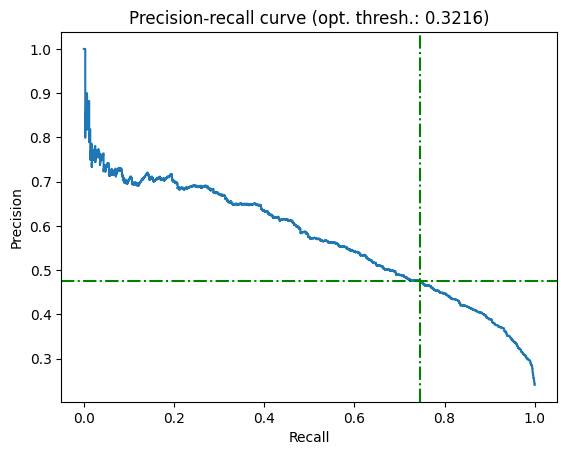

In [94]:
model.eval()
with torch.no_grad():
    # positive class probabilities
    y_pred_valid_score = model.predict_proba(X_valid)
    y_pred_test_score = model.predict_proba(X_test)

auroc = roc_auc_score(y_test, y_pred_test_score)
print(f"AUROC: {100 * auroc:.2f}%")

plot_precision_recall_curve(y_valid, y_pred_valid_score)

AUROC jest podobne, a precision i recall spadły - wypadamy wręcz gorzej od regresji liniowej! Skoro dodaliśmy więcej warstw, to może pojemność modelu jest teraz za duża i trzeba by go zregularyzować?

Sieci neuronowe bardzo łatwo przeuczają, bo są bardzo elastycznymi i pojemnymi modelami. Dlatego mają wiele różnych rodzajów regularyzacji, których używa się razem. Co ciekawe, udowodniono eksperymentalnie, że zbyt duże sieci z mocną regularyzacją działają lepiej niż mniejsze sieci, odpowiedniego rozmiaru, za to ze słabszą regularyzacją.

Pierwszy rodzaj regularyzacji to znana nam już **regularyzacja L2**, czyli penalizacja zbyt dużych wag. W kontekście sieci neuronowych nazywa się też ją czasem *weight decay*. W PyTorchu dodaje się ją jako argument do optymalizatora.

Regularyzacja specyficzna dla sieci neuronowych to **dropout**. Polega on na losowym wyłączaniu zadanego procenta neuronów podczas treningu. Pomimo prostoty okazała się niesamowicie skuteczna, szczególnie w treningu bardzo głębokich sieci. Co ważne, jest to mechanizm używany tylko podczas treningu - w trakcie predykcji za pomocą sieci wyłącza się ten mechanizm i dokonuje normalnie predykcji całą siecią. Podejście to można potraktować jak ensemble learning, podobny do lasów losowych - wyłączając losowe części sieci, w każdej iteracji trenujemy nieco inną sieć, co odpowiada uśrednianiu predykcji różnych algorytmów. Typowo stosuje się dość mocny dropout, rzędu 25-50%. W PyTorchu implementuje go warstwa `nn.Dropout`, aplikowana zazwyczaj po funkcji aktywacji.

Ostatni, a być może najważniejszy rodzaj regularyzacji to **wczesny stop (early stopping)**. W każdym kroku mocniej dostosowujemy terenową sieć do zbioru treningowego, a więc zbyt długi trening będzie skutkował przeuczeniem. W metodzie wczesnego stopu używamy wydzielonego zbioru walidacyjnego (pojedynczego, metoda holdout), sprawdzając co określoną liczbę epok wynik na tym zbiorze. Jeżeli nie uzyskamy wyniku lepszego od najlepszego dotychczas uzyskanego przez określoną liczbę epok, to przerywamy trening. Okres, przez który czekamy na uzyskanie lepszego wyniku, to cierpliwość (*patience*). Im mniejsze, tym mocniejszy jest ten rodzaj regularyzacji, ale trzeba z tym uważać, bo łatwo jest przesadzić i zbyt szybko przerywać trening. Niektóre implementacje uwzględniają tzw. *grace period*, czyli gwarantowaną minimalną liczbę epok, przez którą będziemy trenować sieć, niezależnie od wybranej cierpliwości.

Dodatkowo ryzyko przeuczenia można zmniejszyć, używając mniejszej stałej uczącej.

#### Zadanie 5 (1.5 punktu)

Zaimplementuj funkcję `evaluate_model()`, obliczającą metryki na zbiorze testowym:
- wartość funkcji kosztu (loss)
- AUROC
- optymalny próg
- F1-score przy optymalnym progu
- precyzję oraz recall dla optymalnego progu

Jeżeli podana jest wartość argumentu `threshold`, to użyj jej do zamiany prawdopodobieństw na twarde predykcje. W przeciwnym razie użyj funkcji `get_optimal_threshold` i oblicz optymalną wartość progu.

Pamiętaj o przełączeniu modelu w tryb ewaluacji oraz o wyłączeniu obliczania gradientów.

In [104]:
from typing import Optional

from sklearn.metrics import precision_score, recall_score, f1_score
from torch import sigmoid

def evaluate_model(
    model: nn.Module, 
    X: torch.Tensor, 
    y: torch.Tensor, 
    loss_fn: nn.Module,
    threshold: Optional[float] = None
) -> Dict[str, float]:
    # implement me!


    results = {}

    model.eval()
    with torch.no_grad():
        y_pred = model.predict_proba(X)

    ### LOSS ###
    results['loss'] = loss_fn(y_pred, y )
    
    ### AUROC ###
    results['AUROC'] = roc_auc_score(y, y_pred)
    
    ### OPTIMAL VALUES ###
    precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
    optimal_idx, optimal_threshold = get_optimal_threshold(precisions, recalls, thresholds)

    optimal_precision = precisions[optimal_idx]
    optimal_recall = recalls[optimal_idx]
    optimal_f1 = 2 * optimal_precision * optimal_recall / (optimal_precision + optimal_recall)
    
    results['threshold'] = optimal_threshold
    results['F1-score'] = optimal_f1
    results['precision'] = precisions[optimal_idx]
    results['recall'] = recalls[optimal_idx]

    ### PASSED THRESHOLD ####    
    if threshold is not None:
        with torch.no_grad():
            y_pred = model.predict(X, threshold)

        results['threshold'] = threshold
        results['F1-score'] = f1_score(y, y_pred)
        results['precision'] = precision_score(y, y_pred)
        results['recall'] = recall_score(y, y_pred)
    
    return results


#### Zadanie 6 (0.5 punktu)

Zaimplementuj 3-warstwową sieć MLP z dropout (50%). Rozmiary warstw ukrytych mają wynosić 256 i 128.

In [95]:
class RegularizedMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()

        self.transitions = nn.Sequential(            
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.transitions(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


Opisaliśmy wcześniej podstawowy optymalizator w sieciach neuronowych - spadek wzdłuż gradientu. Jednak wymaga on użycia całego zbioru danych, aby obliczyć gradient, co jest często niewykonalne przez rozmiar zbioru. Dlatego wymyślono **stochastyczny spadek wzdłuż gradientu (stochastic gradient descent, SGD)**, w którym używamy 1 przykładu naraz, liczymy gradient tylko po nim i aktualizujemy parametry. Jest to oczywiście dość grube przybliżenie gradientu, ale pozwala robić szybko dużo małych kroków. Kompromisem, którego używa się w praktyce, jest **minibatch gradient descent**, czyli używanie batchy np. 32, 64 czy 128 przykładów.

Rzadko wspominanym, a ważnym faktem jest także to, że stochastyczność metody optymalizacji jest sama w sobie też [metodą regularyzacji](https://arxiv.org/abs/2101.12176), a więc `batch_size` to także hiperparametr.

Obecnie najpopularniejszą odmianą SGD jest [Adam](https://arxiv.org/abs/1412.6980), gdyż uczy on szybko sieć oraz daje bardzo dobre wyniki nawet przy niekoniecznie idealnie dobranych hiperparametrach. W PyTorchu najlepiej korzystać z jego implementacji `AdamW`, która jest nieco lepsza niż implementacja `Adam`. Jest to zasadniczo zawsze wybór domyślny przy treningu współczesnych sieci neuronowych.

Na razie użyjemy jednak minibatch SGD.

Poniżej znajduje się implementacja prostej klasy dziedziczącej po `Dataset` - tak w PyTorchu implementuje się własne zbiory danych. Użycie takich klas umożliwia użycie klas ładujących dane (`DataLoader`), które z kolei pozwalają łatwo ładować batche danych. Trzeba w takiej klasie zaimplementować metody:
- `__len__` - zwraca ilość punktów w zbiorze
- `__getitem__` - zwraca przykład ze zbioru pod danym indeksem oraz jego klasę


In [96]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, data, y):
        super().__init__()
        
        self.data = data
        self.y = y
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.y[idx]


#### Zadanie 7 (1.5 punktu)

Zaimplementuj pętlę treningowo-walidacyjną dla sieci neuronowej. Wykorzystaj podane wartości hiperparametrów do treningu (stała ucząca, prawdopodobieństwo dropoutu, regularyzacja L2, rozmiar batcha, maksymalna liczba epok). Użyj optymalizatora SGD.

Dodatkowo zaimplementuj regularyzację przez early stopping. Sprawdzaj co epokę wynik na zbiorze walidacyjnym. Użyj podanej wartości patience, a jako metryki po prostu wartości funkcji kosztu. Może się tutaj przydać zaimplementowana funkcja `evaluate_model()`.

Pamiętaj o tym, aby przechowywać najlepszy dotychczasowy wynik walidacyjny oraz najlepszy dotychczasowy model. Zapamiętaj też optymalny próg do klasyfikacji dla najlepszego modelu.

In [97]:
from copy import deepcopy

from torch.utils.data import DataLoader


learning_rate = 1e-3
dropout_p = 0.5
l2_reg = 1e-4
batch_size = 128
max_epochs = 300

early_stopping_patience = 4

In [105]:
model = RegularizedMLP(
    input_size=X_train.shape[1], 
    dropout_p=dropout_p
)
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=l2_reg
)
loss_fn = torch.nn.BCEWithLogitsLoss()

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()

    # note that we are using DataLoader to get batches
    for X_batch, y_batch in train_dataloader:
        # model training
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # model evaluation, early stopping
    
    model.eval()

    valid_metrics = evaluate_model(model, X_valid, y_valid, loss_fn)

    if best_val_loss > valid_metrics['loss']:
        steps_without_improvement = 0

        best_model = deepcopy(model)
        best_val_loss = valid_metrics['loss']
        best_threshold = valid_metrics['threshold']

    else:
        steps_without_improvement += 1
        
        if steps_without_improvement == early_stopping_patience:
            break
    
    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']}")


Epoch 0 train loss: 0.6561, eval loss 0.8409299850463867
Epoch 1 train loss: 0.6428, eval loss 0.8347378969192505
Epoch 2 train loss: 0.6273, eval loss 0.8289541602134705
Epoch 3 train loss: 0.6176, eval loss 0.8235336542129517
Epoch 4 train loss: 0.6047, eval loss 0.8184210658073425
Epoch 5 train loss: 0.5915, eval loss 0.8135877251625061
Epoch 6 train loss: 0.5868, eval loss 0.8090202808380127
Epoch 7 train loss: 0.5759, eval loss 0.8047022223472595
Epoch 8 train loss: 0.5633, eval loss 0.800606369972229
Epoch 9 train loss: 0.5559, eval loss 0.7967148423194885
Epoch 10 train loss: 0.5538, eval loss 0.7930673360824585
Epoch 11 train loss: 0.5467, eval loss 0.7895961403846741
Epoch 12 train loss: 0.5477, eval loss 0.7863551378250122
Epoch 13 train loss: 0.5487, eval loss 0.7832545638084412
Epoch 14 train loss: 0.5344, eval loss 0.7803651094436646
Epoch 15 train loss: 0.5408, eval loss 0.7776179909706116
Epoch 16 train loss: 0.5271, eval loss 0.775051474571228
Epoch 17 train loss: 0.520

In [106]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)

print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

AUROC: 90.09%
F1: 68.32%
Precision: 62.96%
Recall: 74.68%


Wyniki wyglądają już dużo lepiej.

Na koniec laboratorium dołożymy do naszego modelu jeszcze 3 powrzechnie używane techniki, które są bardzo proste, a pozwalają często ulepszyć wynik modelu.

Pierwszą z nich są **warstwy normalizacji (normalization layers)**. Powstały one początkowo z założeniem, że przez przekształcenia przestrzeni dokonywane przez sieć zmienia się rozkład prawdopodobieństw pomiędzy warstwami, czyli tzw. *internal covariate shift*. Później okazało się, że zastosowanie takiej normalizacji wygładza powierzchnię funkcji kosztu, co ułatwia i przyspiesza optymalizację. Najpowszechniej używaną normalizacją jest **batch normalization (batch norm)**.

Drugim ulepszeniem jest dodanie **wag klas (class weights)**. Mamy do czynienia z problemem klasyfikacji niezbalansowanej, więc klasa mniejszościowa, ważniejsza dla nas, powinna dostać większą wagę. Implementuje się to trywialnie prosto - po prostu mnożymy wartość funkcji kosztu dla danego przykładu przez wagę dla prawdziwej klasy tego przykładu. Praktycznie każdy klasyfikator operujący na jakiejś ważonej funkcji może działać w ten sposób, nie tylko sieci neuronowe.

Ostatnim ulepszeniem jest zamiana SGD na optymalizator Adam, a konkretnie na optymalizator `AdamW`. Jest to przykład **optymalizatora adaptacyjnego (adaptive optimizer)**, który potrafi zaadaptować stałą uczącą dla każdego parametru z osobna w trakcie treningu. Wykorzystuje do tego gradienty - w uproszczeniu, im większa wariancja gradientu, tym mniejsze kroki w tym kierunku robimy.

#### Zadanie 8 (0.5 punktu)

Zaimplementuj model `NormalizingMLP`, o takiej samej strukturze jak `RegularizedMLP`, ale dodatkowo z warstwami `BatchNorm1d` pomiędzy warstwami `Linear` oraz `ReLU`.

Za pomocą funkcji `compute_class_weight()` oblicz wagi dla poszczególnych klas. Użyj opcji `"balanced"`. Przekaż do funkcji kosztu wagę klasy pozytywnej (pamiętaj, aby zamienić ją na tensor).

Zamień używany optymalizator na `AdamW`.

Na koniec skopiuj resztę kodu do treningu z poprzedniego zadania, wytrenuj sieć i oblicz wyniki na zbiorze testowym.

In [111]:
class NormalizingMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()

        self.transitions = nn.Sequential(            
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.transitions(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


In [117]:
# define all the hyperparameters
# your_code

from copy import deepcopy
from sklearn.utils import compute_class_weight

from torch.utils.data import DataLoader


learning_rate = 1e-3
dropout_p = 0.5
l2_reg = 1e-4
batch_size = 128
max_epochs = 300

early_stopping_patience = 4

weights = compute_class_weight(
    "balanced",
    classes = np.unique(y),
    y = y
)

In [118]:
# training loop
# your_code


model = NormalizingMLP(
    input_size=X_train.shape[1], 
    dropout_p=dropout_p
)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=l2_reg
)

loss_fn = torch.nn.BCEWithLogitsLoss(
    weight = torch.from_numpy(weights)[1]
)

train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

steps_without_improvement = 0

best_val_loss = np.inf
best_model = None
best_threshold = None

for epoch_num in range(max_epochs):
    model.train()

    # note that we are using DataLoader to get batches
    for X_batch, y_batch in train_dataloader:
        # model training
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # model evaluation, early stopping
    
    model.eval()

    valid_metrics = evaluate_model(model, X_valid, y_valid, loss_fn)

    if best_val_loss > valid_metrics['loss']:
        steps_without_improvement = 0

        best_model = deepcopy(model)
        best_val_loss = valid_metrics['loss']
        best_threshold = valid_metrics['threshold']

    else:
        steps_without_improvement += 1
        
        if steps_without_improvement == early_stopping_patience:
            break
    
    print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']}")


Epoch 0 train loss: 0.7869, eval loss 1.44856595993042
Epoch 1 train loss: 0.7464, eval loss 1.4412180185317993
Epoch 2 train loss: 0.7870, eval loss 1.437193512916565
Epoch 3 train loss: 0.7217, eval loss 1.4344581365585327
Epoch 4 train loss: 0.7118, eval loss 1.4328137636184692
Epoch 5 train loss: 0.7708, eval loss 1.4321856498718262
Epoch 6 train loss: 0.7051, eval loss 1.430405855178833
Epoch 7 train loss: 0.7059, eval loss 1.4293659925460815
Epoch 8 train loss: 0.6812, eval loss 1.4294514656066895
Epoch 9 train loss: 0.7394, eval loss 1.430424690246582
Epoch 10 train loss: 0.7216, eval loss 1.4290835857391357
Epoch 11 train loss: 0.6852, eval loss 1.4301484823226929
Epoch 12 train loss: 0.7425, eval loss 1.4270368814468384
Epoch 13 train loss: 0.6844, eval loss 1.4269318580627441
Epoch 14 train loss: 0.6379, eval loss 1.4273426532745361
Epoch 15 train loss: 0.6733, eval loss 1.4252169132232666
Epoch 16 train loss: 0.6584, eval loss 1.4285341501235962
Epoch 17 train loss: 0.7431, 

In [119]:
test_metrics = evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)

print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

AUROC: 90.73%
F1: 69.41%
Precision: 64.84%
Recall: 74.68%


## Akceleracja sprzętowa (dla zainteresowanych)

Jak wcześniej wspominaliśmy, użycie akceleracji sprzętowej, czyli po prostu GPU do obliczeń, jest bardzo efektywne w przypadku sieci neuronowych. Karty graficzne bardzo efektywnie mnożą macierze, a sieci neuronowe to, jak można było się przekonać, dużo mnożenia macierzy.

W PyTorchu jest to dosyć łatwe, ale trzeba robić to explicite. Służy do tego metoda `.to()`, która przenosi tensory między CPU i GPU. Poniżej przykład, jak to się robi (oczywiście trzeba mieć skonfigurowane GPU, żeby działało):

In [ ]:
import time 


class CudaMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float = 0.5):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 1),
        )
    
    def forward(self, x):
        return self.mlp(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


model = CudaMLP(X_train.shape[1]).to('cuda')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# note that we are using loss function with sigmoid built in
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.from_numpy(weights)[1].to('cuda'))

step_counter = 0
time_from_eval = time.time()
for epoch_id in range(30):
    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to('cuda')
        batch_y = batch_y.to('cuda')
        
        loss = loss_fn(model(batch_x), batch_y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        if step_counter % evaluation_steps == 0:
            print(f"Epoch {epoch_id} train loss: {loss.item():.4f}, time: {time.time() - time_from_eval}")
            time_from_eval = time.time()

        step_counter += 1

test_res = evaluate_model(model.to('cpu'), X_test, y_test, loss_fn.to('cpu'), threshold=0.5)

print(f"AUROC: {100 * test_res['AUROC']:.2f}%")
print(f"F1: {100 * test_res['F1-score']:.2f}%")
print(test_res)

Co prawda ten model nie będzie tak dobry jak ten z laboratorium, ale zwróć uwagę, o ile jest większy, a przy tym szybszy.

Dla zainteresowanych polecamy [tę serie artykułów](https://medium.com/@adi.fu7/ai-accelerators-part-i-intro-822c2cdb4ca4)

## Zadanie dla chętnych

Jak widzieliśmy, sieci neuronowe mają bardzo dużo hiperparametrów. Przeszukiwanie ich grid search'em jest więc niewykonalne, a chociaż random search by działał, to potrzebowałby wielu iteracji, co też jest kosztowne obliczeniowo.

Zaimplementuj inteligentne przeszukiwanie przestrzeni hiperparametrów za pomocą biblioteki [Optuna](https://optuna.org/). Implementuje ona między innymi algorytm Tree Parzen Estimator (TPE), należący do grupy algorytmów typu Bayesian search. Typowo osiągają one bardzo dobre wyniki, a właściwie zawsze lepsze od przeszukiwania losowego. Do tego wystarcza im często niewielka liczba kroków.

Zaimplementuj 3-warstwową sieć MLP, gdzie pierwsza warstwa ma rozmiar ukryty N, a druga N // 2. Ucz ją optymalizatorem Adam przez maksymalnie 300 epok z cierpliwością 10.

Przeszukaj wybrane zakresy dla hiperparametrów:
- rozmiar warstw ukrytych (N)
- stała ucząca
- batch size
- siła regularyzacji L2
- prawdopodobieństwo dropoutu

Wykorzystaj przynajmniej 30 iteracji. Następnie przełącz algorytm na losowy (Optuna także jego implementuje), wykonaj 30 iteracji i porównaj jakość wyników.

Przydatne materiały:
- [Optuna code examples - PyTorch](https://optuna.org/#code_examples)
- [Auto-Tuning Hyperparameters with Optuna and PyTorch](https://www.youtube.com/watch?v=P6NwZVl8ttc)
- [Hyperparameter Tuning of Neural Networks with Optuna and PyTorch](https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837)
- [Using Optuna to Optimize PyTorch Hyperparameters](https://medium.com/pytorch/using-optuna-to-optimize-pytorch-hyperparameters-990607385e36)

In [126]:
class OptimizedMLP(nn.Module):
    def __init__(self, input_size: int, dropout_p: float, hidden_layer_size: int):
        super().__init__()

        n = hidden_layer_size
        n_half = hidden_layer_size // 2

        self.transitions = nn.Sequential(            
            nn.Linear(input_size, n),
            nn.BatchNorm1d(n),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(n, n_half),
            nn.BatchNorm1d(n_half),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(n_half, 1),
        )

    def forward(self, x):
        return self.transitions(x)

    def predict_proba(self, x):
        return sigmoid(self(x))
    
    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)


In [162]:
max_epochs = 150

In [163]:
import optuna

def define_model(trial):
    hidden_layers_size = trial.suggest_int(
        'hidden_layers_size', 
        X_train.shape[1] // 2, 
        2 * X_train.shape[1],
        log = True
    )

    dropout_p = trial.suggest_float(
        'dropout_p',
        0.25,
        0.5,
        log = True
    )

    return OptimizedMLP(
        input_size=X_train.shape[1], 
        dropout_p = dropout_p,
        hidden_layer_size = hidden_layers_size
    )

def train(model, optimizer, loss_fn, batch_size):
    global max_epochs, X_train, y_train, X_valid, y_valid
    train_dataset = MyDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    steps_without_improvement = 0

    best_val_loss = np.inf
    best_model = None
    best_threshold = None

    for epoch_num in range(max_epochs):
        model.train()

        # note that we are using DataLoader to get batches
        for X_batch, y_batch in train_dataloader:
            # model training
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # model evaluation, early stopping
        
        model.eval()

        valid_metrics = evaluate_model(model, X_valid, y_valid, loss_fn)

        if best_val_loss > valid_metrics['loss']:
            steps_without_improvement = 0

            best_model = deepcopy(model)
            best_val_loss = valid_metrics['loss']
            best_threshold = valid_metrics['threshold']

        else:
            steps_without_improvement += 1
            
            if steps_without_improvement == early_stopping_patience:
                break

        print(f"Epoch {epoch_num} train loss: {loss.item():.4f}, eval loss {valid_metrics['loss']}")

    return best_model, best_val_loss, best_threshold

def train_optuna(model, optimizer, loss_fn, batch_size):
    _, loss, _ = train(model, optimizer, loss_fn, batch_size)
    return loss

def objective(trial):
    model = define_model(trial)

    learning_rate = trial.suggest_float(
        'learning_rate', 
        1e-6, 
        1e-1, 
        log = True
    )

    batch_size = trial.suggest_int(
        'batch_size',
        128,
        512,
        log = True
    )

    l2_reg = trial.suggest_float(
        'l2_reg',
        1e-5,
        1e-3,
        log = True
    )

    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=l2_reg
    )

    weights = compute_class_weight(
        "balanced",
        classes = np.unique(y),
        y = y
    )

    loss_fn = torch.nn.BCEWithLogitsLoss(
        weight = torch.from_numpy(weights)[1]
    )

    return train_optuna(model, optimizer, loss_fn, batch_size)


In [164]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2023-11-26 19:38:50,215] A new study created in memory with name: no-name-f220af00-cc84-4850-9f86-164e31e35988


Epoch 0 train loss: 0.6165, eval loss 1.4268232583999634
Epoch 1 train loss: 0.3124, eval loss 1.4239012002944946
Epoch 2 train loss: 0.3173, eval loss 1.4223229885101318
Epoch 3 train loss: 0.4300, eval loss 1.4196330308914185
Epoch 4 train loss: 0.3357, eval loss 1.42090904712677
Epoch 5 train loss: 0.3804, eval loss 1.4262138605117798
Epoch 6 train loss: 0.2801, eval loss 1.4227888584136963


[I 2023-11-26 19:38:55,868] Trial 0 finished with value: 1.4196330308914185 and parameters: {'hidden_layers_size': 185, 'dropout_p': 0.4068804799715802, 'learning_rate': 0.010978991823991393, 'batch_size': 336, 'l2_reg': 1.34641142059497e-05}. Best is trial 0 with value: 1.4196330308914185.


Epoch 0 train loss: 1.4006, eval loss 1.8089185953140259
Epoch 1 train loss: 1.3063, eval loss 1.8107423782348633
Epoch 2 train loss: 1.5072, eval loss 1.8080438375473022
Epoch 3 train loss: 1.2947, eval loss 1.8089221715927124
Epoch 4 train loss: 1.5810, eval loss 1.8088653087615967
Epoch 5 train loss: 1.2184, eval loss 1.803401231765747
Epoch 6 train loss: 1.5646, eval loss 1.8060569763183594
Epoch 7 train loss: 1.5708, eval loss 1.8051623106002808
Epoch 8 train loss: 1.2308, eval loss 1.805528163909912


[I 2023-11-26 19:39:04,094] Trial 1 finished with value: 1.803401231765747 and parameters: {'hidden_layers_size': 87, 'dropout_p': 0.489907983890005, 'learning_rate': 1.5461728272636294e-06, 'batch_size': 217, 'l2_reg': 3.202440992612983e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.0667, eval loss 1.639102816581726
Epoch 1 train loss: 0.9433, eval loss 1.5832183361053467
Epoch 2 train loss: 0.8702, eval loss 1.5496737957000732
Epoch 3 train loss: 0.7843, eval loss 1.5267010927200317
Epoch 4 train loss: 0.7905, eval loss 1.5078661441802979
Epoch 5 train loss: 0.7655, eval loss 1.4926570653915405
Epoch 6 train loss: 0.7302, eval loss 1.4817637205123901
Epoch 7 train loss: 0.7016, eval loss 1.4728914499282837
Epoch 8 train loss: 0.6590, eval loss 1.4652535915374756
Epoch 9 train loss: 0.6883, eval loss 1.4596012830734253
Epoch 10 train loss: 0.6854, eval loss 1.454770803451538
Epoch 11 train loss: 0.6550, eval loss 1.4515832662582397
Epoch 12 train loss: 0.6722, eval loss 1.4480564594268799
Epoch 13 train loss: 0.6607, eval loss 1.4452193975448608
Epoch 14 train loss: 0.6588, eval loss 1.4436118602752686
Epoch 15 train loss: 0.6329, eval loss 1.442274808883667
Epoch 16 train loss: 0.6586, eval loss 1.441723108291626
Epoch 17 train loss: 0.6220,

[I 2023-11-26 19:39:24,705] Trial 2 finished with value: 1.4301395416259766 and parameters: {'hidden_layers_size': 65, 'dropout_p': 0.2828372333521446, 'learning_rate': 0.0003532557894056364, 'batch_size': 480, 'l2_reg': 0.0009952730340921808}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.0391, eval loss 1.5901604890823364
Epoch 1 train loss: 1.0020, eval loss 1.5303393602371216
Epoch 2 train loss: 0.8757, eval loss 1.4990736246109009
Epoch 3 train loss: 0.7983, eval loss 1.481130838394165
Epoch 4 train loss: 0.8153, eval loss 1.4686423540115356
Epoch 5 train loss: 0.7615, eval loss 1.4606677293777466
Epoch 6 train loss: 0.7651, eval loss 1.4554810523986816
Epoch 7 train loss: 0.6799, eval loss 1.451284646987915
Epoch 8 train loss: 0.6614, eval loss 1.4473800659179688
Epoch 9 train loss: 0.6153, eval loss 1.444901466369629
Epoch 10 train loss: 0.6636, eval loss 1.4433597326278687
Epoch 11 train loss: 0.5631, eval loss 1.4416804313659668
Epoch 12 train loss: 0.5281, eval loss 1.4404723644256592
Epoch 13 train loss: 0.6120, eval loss 1.4387907981872559
Epoch 14 train loss: 0.6434, eval loss 1.4377154111862183
Epoch 15 train loss: 0.5691, eval loss 1.4362729787826538
Epoch 16 train loss: 0.5504, eval loss 1.4362157583236694
Epoch 17 train loss: 0.5421

[I 2023-11-26 19:39:50,437] Trial 3 finished with value: 1.4306191205978394 and parameters: {'hidden_layers_size': 189, 'dropout_p': 0.335446125087379, 'learning_rate': 0.00018634702171506481, 'batch_size': 260, 'l2_reg': 6.065164275108682e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 0.7101, eval loss 1.4648549556732178
Epoch 1 train loss: 0.6525, eval loss 1.4420949220657349
Epoch 2 train loss: 0.6222, eval loss 1.4417181015014648
Epoch 3 train loss: 0.6030, eval loss 1.4371815919876099
Epoch 4 train loss: 0.5852, eval loss 1.437233328819275
Epoch 5 train loss: 0.5928, eval loss 1.4368410110473633
Epoch 6 train loss: 0.5767, eval loss 1.436415672302246
Epoch 7 train loss: 0.6206, eval loss 1.434099555015564
Epoch 8 train loss: 0.5776, eval loss 1.4362107515335083
Epoch 9 train loss: 0.5927, eval loss 1.4324151277542114
Epoch 10 train loss: 0.5776, eval loss 1.433035135269165
Epoch 11 train loss: 0.5652, eval loss 1.4331684112548828
Epoch 12 train loss: 0.5829, eval loss 1.433249831199646


[I 2023-11-26 19:39:58,782] Trial 4 finished with value: 1.4324151277542114 and parameters: {'hidden_layers_size': 111, 'dropout_p': 0.3002039437138742, 'learning_rate': 0.0029727208396297736, 'batch_size': 479, 'l2_reg': 0.0004831397700544172}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.2200, eval loss 1.4228744506835938
Epoch 1 train loss: 1.5240, eval loss 1.424627661705017
Epoch 2 train loss: 0.5862, eval loss 1.4265384674072266
Epoch 3 train loss: 0.7615, eval loss 1.4238454103469849


[I 2023-11-26 19:40:02,430] Trial 5 finished with value: 1.4228744506835938 and parameters: {'hidden_layers_size': 100, 'dropout_p': 0.30626568843058916, 'learning_rate': 0.01473230680293548, 'batch_size': 251, 'l2_reg': 2.3166256377940516e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.6699, eval loss 1.8016992807388306
Epoch 1 train loss: 1.6497, eval loss 1.7856029272079468
Epoch 2 train loss: 1.5298, eval loss 1.7725859880447388
Epoch 3 train loss: 1.4894, eval loss 1.759587049484253
Epoch 4 train loss: 1.5360, eval loss 1.7461634874343872
Epoch 5 train loss: 1.4696, eval loss 1.735628366470337
Epoch 6 train loss: 1.4066, eval loss 1.7246735095977783
Epoch 7 train loss: 1.4880, eval loss 1.7139297723770142
Epoch 8 train loss: 1.3360, eval loss 1.7058454751968384
Epoch 9 train loss: 1.3030, eval loss 1.6972993612289429
Epoch 10 train loss: 1.2669, eval loss 1.688965082168579
Epoch 11 train loss: 1.2152, eval loss 1.6797707080841064
Epoch 12 train loss: 1.2954, eval loss 1.6718412637710571
Epoch 13 train loss: 1.3042, eval loss 1.6656986474990845
Epoch 14 train loss: 1.2156, eval loss 1.6593745946884155
Epoch 15 train loss: 1.1645, eval loss 1.6524603366851807
Epoch 16 train loss: 1.1380, eval loss 1.6486958265304565
Epoch 17 train loss: 1.1759

[I 2023-11-26 19:42:11,962] Trial 6 finished with value: 1.4420490264892578 and parameters: {'hidden_layers_size': 84, 'dropout_p': 0.355192902719554, 'learning_rate': 1.1856994355524345e-05, 'batch_size': 147, 'l2_reg': 1.1533970697156625e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 0.7004, eval loss 1.4422955513000488
Epoch 0 train loss: 0.7592, eval loss 1.4392565488815308
Epoch 1 train loss: 0.7097, eval loss 1.4312855005264282
Epoch 2 train loss: 0.6643, eval loss 1.427862286567688
Epoch 3 train loss: 0.6484, eval loss 1.4265140295028687
Epoch 4 train loss: 0.6531, eval loss 1.4262874126434326
Epoch 5 train loss: 0.7326, eval loss 1.4252033233642578
Epoch 6 train loss: 0.6856, eval loss 1.4260015487670898
Epoch 7 train loss: 0.6636, eval loss 1.4266576766967773
Epoch 8 train loss: 0.6856, eval loss 1.425023078918457
Epoch 9 train loss: 0.5903, eval loss 1.4265354871749878
Epoch 10 train loss: 0.6423, eval loss 1.4254704713821411
Epoch 11 train loss: 0.6942, eval loss 1.4237393140792847
Epoch 12 train loss: 0.6342, eval loss 1.4245840311050415
Epoch 13 train loss: 0.5949, eval loss 1.4243565797805786
Epoch 14 train loss: 0.6283, eval loss 1.4231367111206055
Epoch 15 train loss: 0.6178, eval loss 1.4227485656738281
Epoch 16 train loss: 0.70

[I 2023-11-26 19:42:43,105] Trial 7 finished with value: 1.422120213508606 and parameters: {'hidden_layers_size': 135, 'dropout_p': 0.2877508594801334, 'learning_rate': 0.0012921275464269674, 'batch_size': 134, 'l2_reg': 0.00010354605429446324}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 0.6664, eval loss 1.4368209838867188
Epoch 1 train loss: 0.6912, eval loss 1.4383376836776733
Epoch 2 train loss: 0.6330, eval loss 1.439626932144165
Epoch 3 train loss: 0.6815, eval loss 1.4426182508468628


[I 2023-11-26 19:42:46,498] Trial 8 finished with value: 1.4368209838867188 and parameters: {'hidden_layers_size': 57, 'dropout_p': 0.39520546062488676, 'learning_rate': 0.04739320270422495, 'batch_size': 299, 'l2_reg': 0.00027050363398514217}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 0.7169, eval loss 1.437097430229187
Epoch 1 train loss: 0.6942, eval loss 1.4335131645202637
Epoch 2 train loss: 0.6211, eval loss 1.4369632005691528
Epoch 3 train loss: 0.5548, eval loss 1.432682752609253
Epoch 4 train loss: 0.4627, eval loss 1.4263136386871338
Epoch 5 train loss: 0.4237, eval loss 1.4300023317337036
Epoch 6 train loss: 0.4951, eval loss 1.4350719451904297
Epoch 7 train loss: 0.4578, eval loss 1.4267882108688354


[I 2023-11-26 19:42:52,393] Trial 9 finished with value: 1.4263136386871338 and parameters: {'hidden_layers_size': 54, 'dropout_p': 0.27146235362128895, 'learning_rate': 0.033780962695344606, 'batch_size': 416, 'l2_reg': 0.0005398007559151257}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.6318, eval loss 1.7973930835723877
Epoch 1 train loss: 1.6002, eval loss 1.796926736831665
Epoch 2 train loss: 1.6157, eval loss 1.7940939664840698
Epoch 3 train loss: 1.5813, eval loss 1.7941765785217285
Epoch 4 train loss: 1.6756, eval loss 1.7914142608642578
Epoch 5 train loss: 1.6057, eval loss 1.792375087738037
Epoch 6 train loss: 1.6146, eval loss 1.7913492918014526
Epoch 7 train loss: 1.5977, eval loss 1.7900804281234741
Epoch 8 train loss: 1.5971, eval loss 1.7896268367767334
Epoch 9 train loss: 1.5961, eval loss 1.7872806787490845
Epoch 10 train loss: 1.5491, eval loss 1.7876583337783813
Epoch 11 train loss: 1.5600, eval loss 1.786561131477356
Epoch 12 train loss: 1.5939, eval loss 1.7874130010604858
Epoch 13 train loss: 1.5272, eval loss 1.7850030660629272
Epoch 14 train loss: 1.5095, eval loss 1.7855640649795532
Epoch 15 train loss: 1.5599, eval loss 1.78235924243927
Epoch 16 train loss: 1.6034, eval loss 1.7819253206253052
Epoch 17 train loss: 1.4992, 

[I 2023-11-26 19:44:28,580] Trial 10 finished with value: 1.713407039642334 and parameters: {'hidden_layers_size': 78, 'dropout_p': 0.4910729724376275, 'learning_rate': 1.1621568817979394e-06, 'batch_size': 185, 'l2_reg': 3.8426680434817866e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.3505, eval loss 1.7458510398864746
Epoch 1 train loss: 1.4506, eval loss 1.7476296424865723
Epoch 2 train loss: 1.6246, eval loss 1.7434031963348389
Epoch 3 train loss: 1.3902, eval loss 1.7433992624282837
Epoch 4 train loss: 1.2796, eval loss 1.742552399635315
Epoch 5 train loss: 1.5304, eval loss 1.7440767288208008
Epoch 6 train loss: 1.3807, eval loss 1.7423486709594727
Epoch 7 train loss: 1.4468, eval loss 1.7437301874160767
Epoch 8 train loss: 1.3772, eval loss 1.7398512363433838
Epoch 9 train loss: 1.3458, eval loss 1.7365080118179321
Epoch 10 train loss: 1.4339, eval loss 1.738708257675171
Epoch 11 train loss: 1.4199, eval loss 1.73784601688385
Epoch 12 train loss: 1.3294, eval loss 1.7347745895385742
Epoch 13 train loss: 1.3824, eval loss 1.7365102767944336
Epoch 14 train loss: 1.3253, eval loss 1.7370673418045044
Epoch 15 train loss: 1.4182, eval loss 1.7333968877792358
Epoch 16 train loss: 1.4185, eval loss 1.7358115911483765
Epoch 17 train loss: 1.3776,

[I 2023-11-26 19:45:39,739] Trial 11 finished with value: 1.6716227531433105 and parameters: {'hidden_layers_size': 79, 'dropout_p': 0.4995540527585774, 'learning_rate': 1.0013372175504955e-06, 'batch_size': 189, 'l2_reg': 5.62465192894945e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.4351, eval loss 1.761287808418274
Epoch 1 train loss: 1.4471, eval loss 1.761607050895691
Epoch 2 train loss: 1.4363, eval loss 1.7590199708938599
Epoch 3 train loss: 1.4894, eval loss 1.757539987564087
Epoch 4 train loss: 1.4315, eval loss 1.7598501443862915
Epoch 5 train loss: 1.4426, eval loss 1.7580764293670654
Epoch 6 train loss: 1.4760, eval loss 1.7573615312576294
Epoch 7 train loss: 1.4877, eval loss 1.7588859796524048
Epoch 8 train loss: 1.5256, eval loss 1.7556606531143188
Epoch 9 train loss: 1.4199, eval loss 1.7555103302001953
Epoch 10 train loss: 1.5000, eval loss 1.7545783519744873
Epoch 11 train loss: 1.3404, eval loss 1.7536920309066772
Epoch 12 train loss: 1.3763, eval loss 1.7520778179168701
Epoch 13 train loss: 1.3986, eval loss 1.752812147140503
Epoch 14 train loss: 1.4000, eval loss 1.7498860359191895
Epoch 15 train loss: 1.3531, eval loss 1.7502676248550415
Epoch 16 train loss: 1.4340, eval loss 1.749920129776001
Epoch 17 train loss: 1.4970, 

[I 2023-11-26 19:46:42,914] Trial 12 finished with value: 1.6934962272644043 and parameters: {'hidden_layers_size': 71, 'dropout_p': 0.4939836605682455, 'learning_rate': 1.033644192116278e-06, 'batch_size': 194, 'l2_reg': 2.9209239251884415e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.5979, eval loss 1.7865238189697266
Epoch 1 train loss: 1.5293, eval loss 1.7772608995437622
Epoch 2 train loss: 1.4897, eval loss 1.7661323547363281
Epoch 3 train loss: 1.4827, eval loss 1.7574682235717773
Epoch 4 train loss: 1.4255, eval loss 1.7513375282287598
Epoch 5 train loss: 1.4739, eval loss 1.743520975112915
Epoch 6 train loss: 1.3635, eval loss 1.7355067729949951
Epoch 7 train loss: 1.3755, eval loss 1.7291876077651978
Epoch 8 train loss: 1.3983, eval loss 1.7203670740127563
Epoch 9 train loss: 1.3532, eval loss 1.7151226997375488
Epoch 10 train loss: 1.2783, eval loss 1.7068841457366943
Epoch 11 train loss: 1.1985, eval loss 1.7004923820495605
Epoch 12 train loss: 1.1922, eval loss 1.6932398080825806
Epoch 13 train loss: 1.2779, eval loss 1.6890958547592163
Epoch 14 train loss: 1.2338, eval loss 1.6832895278930664
Epoch 15 train loss: 1.2380, eval loss 1.6787375211715698
Epoch 16 train loss: 1.1496, eval loss 1.6729170083999634
Epoch 17 train loss: 1.17

[I 2023-11-26 19:48:15,033] Trial 13 finished with value: 1.4605149030685425 and parameters: {'hidden_layers_size': 90, 'dropout_p': 0.4494963209683946, 'learning_rate': 9.15472107702422e-06, 'batch_size': 192, 'l2_reg': 3.1114172681127265e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 0.8082, eval loss 1.4607032537460327
Epoch 0 train loss: 1.4237, eval loss 1.777103066444397
Epoch 1 train loss: 1.4358, eval loss 1.7700467109680176
Epoch 2 train loss: 1.6049, eval loss 1.7624844312667847
Epoch 3 train loss: 1.5080, eval loss 1.7560837268829346
Epoch 4 train loss: 1.4703, eval loss 1.7485874891281128
Epoch 5 train loss: 1.4186, eval loss 1.7424554824829102
Epoch 6 train loss: 1.3537, eval loss 1.7363533973693848
Epoch 7 train loss: 1.1912, eval loss 1.731629729270935
Epoch 8 train loss: 1.3146, eval loss 1.7257176637649536
Epoch 9 train loss: 1.4118, eval loss 1.7181777954101562
Epoch 10 train loss: 1.2648, eval loss 1.714492678642273
Epoch 11 train loss: 1.4052, eval loss 1.7104334831237793
Epoch 12 train loss: 1.2246, eval loss 1.7051151990890503
Epoch 13 train loss: 1.2678, eval loss 1.6993274688720703
Epoch 14 train loss: 1.2306, eval loss 1.6943269968032837
Epoch 15 train loss: 1.1662, eval loss 1.690213918685913
Epoch 16 train loss: 1.2703

[I 2023-11-26 19:49:56,093] Trial 14 finished with value: 1.4745573997497559 and parameters: {'hidden_layers_size': 73, 'dropout_p': 0.4487116717919587, 'learning_rate': 7.333617542604693e-06, 'batch_size': 165, 'l2_reg': 8.575543293736724e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 0.7016, eval loss 1.4751015901565552
Epoch 0 train loss: 1.4657, eval loss 1.7590045928955078
Epoch 1 train loss: 1.3376, eval loss 1.7187418937683105
Epoch 2 train loss: 1.2415, eval loss 1.6887831687927246
Epoch 3 train loss: 1.1990, eval loss 1.664432168006897
Epoch 4 train loss: 1.1063, eval loss 1.6439323425292969
Epoch 5 train loss: 1.0439, eval loss 1.6281195878982544
Epoch 6 train loss: 0.9804, eval loss 1.6134161949157715
Epoch 7 train loss: 0.9675, eval loss 1.6012543439865112
Epoch 8 train loss: 0.9640, eval loss 1.5894718170166016
Epoch 9 train loss: 0.8970, eval loss 1.579715609550476
Epoch 10 train loss: 0.9028, eval loss 1.5691709518432617
Epoch 11 train loss: 0.8642, eval loss 1.5611250400543213
Epoch 12 train loss: 0.8643, eval loss 1.5530167818069458
Epoch 13 train loss: 0.8394, eval loss 1.5453025102615356
Epoch 14 train loss: 0.8127, eval loss 1.539689540863037
Epoch 15 train loss: 0.7857, eval loss 1.5333051681518555
Epoch 16 train loss: 0.832

[I 2023-11-26 19:50:53,195] Trial 15 finished with value: 1.4313517808914185 and parameters: {'hidden_layers_size': 115, 'dropout_p': 0.2531603926074821, 'learning_rate': 3.7253343416482775e-05, 'batch_size': 215, 'l2_reg': 1.9092539539330737e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.7144, eval loss 1.786270022392273
Epoch 1 train loss: 1.5476, eval loss 1.7817648649215698
Epoch 2 train loss: 1.5744, eval loss 1.779555320739746
Epoch 3 train loss: 1.7134, eval loss 1.7772307395935059
Epoch 4 train loss: 1.5446, eval loss 1.7724343538284302
Epoch 5 train loss: 1.6539, eval loss 1.7685959339141846
Epoch 6 train loss: 1.5811, eval loss 1.76680326461792
Epoch 7 train loss: 1.6468, eval loss 1.765135645866394
Epoch 8 train loss: 1.6630, eval loss 1.7624340057373047
Epoch 9 train loss: 1.4899, eval loss 1.758819580078125
Epoch 10 train loss: 1.6336, eval loss 1.7547831535339355
Epoch 11 train loss: 1.3787, eval loss 1.751784086227417
Epoch 12 train loss: 1.4748, eval loss 1.7488884925842285
Epoch 13 train loss: 1.4539, eval loss 1.7456883192062378
Epoch 14 train loss: 1.3625, eval loss 1.7426722049713135
Epoch 15 train loss: 1.3371, eval loss 1.7398943901062012
Epoch 16 train loss: 1.4768, eval loss 1.7363457679748535
Epoch 17 train loss: 1.5363, ev

[I 2023-11-26 19:52:31,844] Trial 16 finished with value: 1.5469430685043335 and parameters: {'hidden_layers_size': 88, 'dropout_p': 0.4522788736177, 'learning_rate': 3.1629953132741747e-06, 'batch_size': 160, 'l2_reg': 4.099293694265519e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 0.8466, eval loss 1.5469430685043335
Epoch 0 train loss: 1.4749, eval loss 1.7728410959243774
Epoch 1 train loss: 1.4255, eval loss 1.7479106187820435
Epoch 2 train loss: 1.3062, eval loss 1.7252166271209717
Epoch 3 train loss: 1.2784, eval loss 1.7031853199005127
Epoch 4 train loss: 1.1953, eval loss 1.6845165491104126
Epoch 5 train loss: 1.2204, eval loss 1.6656266450881958
Epoch 6 train loss: 1.1710, eval loss 1.6514856815338135
Epoch 7 train loss: 1.2647, eval loss 1.6378757953643799
Epoch 8 train loss: 1.0162, eval loss 1.6219855546951294
Epoch 9 train loss: 1.0394, eval loss 1.6117557287216187
Epoch 10 train loss: 1.0019, eval loss 1.6023176908493042
Epoch 11 train loss: 1.0163, eval loss 1.5910587310791016
Epoch 12 train loss: 0.9322, eval loss 1.580617070198059
Epoch 13 train loss: 0.9432, eval loss 1.5730935335159302
Epoch 14 train loss: 0.8868, eval loss 1.5639398097991943
Epoch 15 train loss: 0.9143, eval loss 1.556567668914795
Epoch 16 train loss: 0.93

[I 2023-11-26 19:53:22,277] Trial 17 finished with value: 1.441368579864502 and parameters: {'hidden_layers_size': 98, 'dropout_p': 0.49977313487729114, 'learning_rate': 4.4882934157749176e-05, 'batch_size': 233, 'l2_reg': 1.797092635932884e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.5185, eval loss 1.7818670272827148
Epoch 1 train loss: 1.5892, eval loss 1.7793103456497192
Epoch 2 train loss: 1.4807, eval loss 1.7737443447113037
Epoch 3 train loss: 1.4993, eval loss 1.772374153137207
Epoch 4 train loss: 1.4975, eval loss 1.7692302465438843
Epoch 5 train loss: 1.4759, eval loss 1.7674707174301147
Epoch 6 train loss: 1.4724, eval loss 1.7641863822937012
Epoch 7 train loss: 1.5820, eval loss 1.7622827291488647
Epoch 8 train loss: 1.5265, eval loss 1.7618460655212402
Epoch 9 train loss: 1.4430, eval loss 1.7570180892944336
Epoch 10 train loss: 1.4452, eval loss 1.7538065910339355
Epoch 11 train loss: 1.4392, eval loss 1.7512365579605103
Epoch 12 train loss: 1.4346, eval loss 1.7500845193862915
Epoch 13 train loss: 1.4426, eval loss 1.7465213537216187
Epoch 14 train loss: 1.3959, eval loss 1.7452397346496582
Epoch 15 train loss: 1.4705, eval loss 1.7425554990768433
Epoch 16 train loss: 1.4072, eval loss 1.7409945726394653
Epoch 17 train loss: 1.42

[I 2023-11-26 22:56:36,070] Trial 18 finished with value: 1.5564539432525635 and parameters: {'hidden_layers_size': 64, 'dropout_p': 0.402003374821153, 'learning_rate': 2.925001742148384e-06, 'batch_size': 128, 'l2_reg': 0.00014214787537244022}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 0.9608, eval loss 1.5564539432525635
Epoch 0 train loss: 1.4237, eval loss 1.7518784999847412
Epoch 1 train loss: 1.3585, eval loss 1.7327529191970825
Epoch 2 train loss: 1.2998, eval loss 1.7173981666564941
Epoch 3 train loss: 1.2192, eval loss 1.701725721359253
Epoch 4 train loss: 1.2220, eval loss 1.6877527236938477
Epoch 5 train loss: 1.1711, eval loss 1.6736961603164673
Epoch 6 train loss: 1.1422, eval loss 1.660018801689148
Epoch 7 train loss: 1.0869, eval loss 1.6502035856246948
Epoch 8 train loss: 1.0851, eval loss 1.6387524604797363
Epoch 9 train loss: 1.0721, eval loss 1.6298624277114868
Epoch 10 train loss: 1.0508, eval loss 1.620577335357666
Epoch 11 train loss: 1.0140, eval loss 1.6112985610961914
Epoch 12 train loss: 1.0173, eval loss 1.6012847423553467
Epoch 13 train loss: 0.9918, eval loss 1.5942553281784058
Epoch 14 train loss: 0.9412, eval loss 1.5863847732543945
Epoch 15 train loss: 0.9572, eval loss 1.5790684223175049
Epoch 16 train loss: 0.880

[I 2023-11-27 11:42:41,064] Trial 19 finished with value: 1.4460344314575195 and parameters: {'hidden_layers_size': 75, 'dropout_p': 0.4588624374776901, 'learning_rate': 2.7174157288421963e-05, 'batch_size': 171, 'l2_reg': 4.677829356538687e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.4269, eval loss 1.7673331499099731
Epoch 1 train loss: 1.4530, eval loss 1.7630044221878052
Epoch 2 train loss: 1.3523, eval loss 1.7583152055740356
Epoch 3 train loss: 1.3817, eval loss 1.7568224668502808
Epoch 4 train loss: 1.4731, eval loss 1.7527133226394653
Epoch 5 train loss: 1.3015, eval loss 1.7478392124176025
Epoch 6 train loss: 1.4865, eval loss 1.7453664541244507
Epoch 7 train loss: 1.4300, eval loss 1.7425817251205444
Epoch 8 train loss: 1.2708, eval loss 1.738852620124817
Epoch 9 train loss: 1.2890, eval loss 1.7351007461547852
Epoch 10 train loss: 1.2935, eval loss 1.7327368259429932
Epoch 11 train loss: 1.3577, eval loss 1.7305092811584473
Epoch 12 train loss: 1.3683, eval loss 1.7265955209732056
Epoch 13 train loss: 1.2783, eval loss 1.7229878902435303
Epoch 14 train loss: 1.3557, eval loss 1.720778465270996
Epoch 15 train loss: 1.2791, eval loss 1.7178107500076294
Epoch 16 train loss: 1.3057, eval loss 1.7160099744796753
Epoch 17 train loss: 1.299

[I 2023-11-27 11:44:11,008] Trial 20 finished with value: 1.5322023630142212 and parameters: {'hidden_layers_size': 122, 'dropout_p': 0.41861694589624343, 'learning_rate': 3.0356108100441192e-06, 'batch_size': 212, 'l2_reg': 3.439449349888914e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 0.8130, eval loss 1.5334504842758179
Epoch 0 train loss: 1.3047, eval loss 1.725730299949646
Epoch 1 train loss: 1.2731, eval loss 1.7242501974105835
Epoch 2 train loss: 1.1229, eval loss 1.7224653959274292
Epoch 3 train loss: 1.2695, eval loss 1.7231342792510986
Epoch 4 train loss: 1.2164, eval loss 1.7227023839950562
Epoch 5 train loss: 1.3150, eval loss 1.7227174043655396


[I 2023-11-27 11:44:15,504] Trial 21 finished with value: 1.7224653959274292 and parameters: {'hidden_layers_size': 71, 'dropout_p': 0.49736577627839546, 'learning_rate': 1.0551039883362064e-06, 'batch_size': 198, 'l2_reg': 2.6094790630653748e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.3705, eval loss 1.733750581741333
Epoch 1 train loss: 1.3743, eval loss 1.731155514717102
Epoch 2 train loss: 1.3849, eval loss 1.7319997549057007
Epoch 3 train loss: 1.2764, eval loss 1.7319679260253906
Epoch 4 train loss: 1.3692, eval loss 1.7291090488433838
Epoch 5 train loss: 1.3313, eval loss 1.728620171546936
Epoch 6 train loss: 1.3177, eval loss 1.7274119853973389
Epoch 7 train loss: 1.3013, eval loss 1.7271579504013062
Epoch 8 train loss: 1.2869, eval loss 1.7253220081329346
Epoch 9 train loss: 1.3078, eval loss 1.7242521047592163
Epoch 10 train loss: 1.3349, eval loss 1.7224780321121216
Epoch 11 train loss: 1.2946, eval loss 1.7216899394989014
Epoch 12 train loss: 1.2717, eval loss 1.7211766242980957
Epoch 13 train loss: 1.3488, eval loss 1.7201303243637085
Epoch 14 train loss: 1.3259, eval loss 1.7197123765945435
Epoch 15 train loss: 1.3178, eval loss 1.716759443283081
Epoch 16 train loss: 1.3303, eval loss 1.7160741090774536
Epoch 17 train loss: 1.3054,

[I 2023-11-27 11:45:39,605] Trial 22 finished with value: 1.6054496765136719 and parameters: {'hidden_layers_size': 84, 'dropout_p': 0.47029535203187567, 'learning_rate': 1.4477541362750555e-06, 'batch_size': 185, 'l2_reg': 2.360547036473938e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 1.0208, eval loss 1.6054496765136719
Epoch 0 train loss: 1.5935, eval loss 1.7880141735076904
Epoch 1 train loss: 1.5351, eval loss 1.7857710123062134
Epoch 2 train loss: 1.5461, eval loss 1.7841145992279053
Epoch 3 train loss: 1.4897, eval loss 1.7827039957046509
Epoch 4 train loss: 1.4503, eval loss 1.7825782299041748
Epoch 5 train loss: 1.5530, eval loss 1.781283974647522
Epoch 6 train loss: 1.5136, eval loss 1.779823899269104
Epoch 7 train loss: 1.5754, eval loss 1.7769471406936646
Epoch 8 train loss: 1.5425, eval loss 1.7757607698440552
Epoch 9 train loss: 1.5614, eval loss 1.7736562490463257
Epoch 10 train loss: 1.4793, eval loss 1.7723870277404785
Epoch 11 train loss: 1.4729, eval loss 1.7714372873306274
Epoch 12 train loss: 1.4448, eval loss 1.771135687828064
Epoch 13 train loss: 1.4714, eval loss 1.768185019493103
Epoch 14 train loss: 1.4410, eval loss 1.7664580345153809
Epoch 15 train loss: 1.4678, eval loss 1.7658615112304688
Epoch 16 train loss: 1.4633

[I 2023-11-27 11:46:49,695] Trial 23 finished with value: 1.6219995021820068 and parameters: {'hidden_layers_size': 65, 'dropout_p': 0.4748843483501442, 'learning_rate': 2.9979960530676105e-06, 'batch_size': 218, 'l2_reg': 1.6027807222253194e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 1.0009, eval loss 1.6235897541046143
Epoch 0 train loss: 1.6496, eval loss 1.8034542798995972
Epoch 1 train loss: 1.6724, eval loss 1.7963709831237793
Epoch 2 train loss: 1.5607, eval loss 1.7871358394622803
Epoch 3 train loss: 1.5602, eval loss 1.7805551290512085
Epoch 4 train loss: 1.6096, eval loss 1.7757809162139893
Epoch 5 train loss: 1.5294, eval loss 1.7659406661987305
Epoch 6 train loss: 1.4712, eval loss 1.759475827217102
Epoch 7 train loss: 1.5088, eval loss 1.7517280578613281
Epoch 8 train loss: 1.4498, eval loss 1.7465214729309082
Epoch 9 train loss: 1.4121, eval loss 1.7404727935791016
Epoch 10 train loss: 1.3451, eval loss 1.734407663345337
Epoch 11 train loss: 1.3423, eval loss 1.7313398122787476
Epoch 12 train loss: 1.3664, eval loss 1.7253390550613403
Epoch 13 train loss: 1.3494, eval loss 1.717074990272522
Epoch 14 train loss: 1.3497, eval loss 1.7133262157440186
Epoch 15 train loss: 1.3323, eval loss 1.7084074020385742
Epoch 16 train loss: 1.351

[I 2023-11-27 11:48:17,888] Trial 24 finished with value: 1.4707778692245483 and parameters: {'hidden_layers_size': 96, 'dropout_p': 0.4317841855591858, 'learning_rate': 6.154684650866806e-06, 'batch_size': 151, 'l2_reg': 3.686034660496669e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 0.7528, eval loss 1.4707778692245483
Epoch 0 train loss: 1.2679, eval loss 1.770382285118103
Epoch 1 train loss: 1.2088, eval loss 1.7655798196792603
Epoch 2 train loss: 1.3492, eval loss 1.7646434307098389
Epoch 3 train loss: 1.3397, eval loss 1.7632484436035156
Epoch 4 train loss: 1.3373, eval loss 1.7616194486618042
Epoch 5 train loss: 1.1794, eval loss 1.7616240978240967
Epoch 6 train loss: 1.4206, eval loss 1.7612793445587158
Epoch 7 train loss: 1.4506, eval loss 1.7612364292144775
Epoch 8 train loss: 1.4705, eval loss 1.754624366760254
Epoch 9 train loss: 1.1209, eval loss 1.756594181060791
Epoch 10 train loss: 1.5553, eval loss 1.7512987852096558
Epoch 11 train loss: 1.3383, eval loss 1.7509173154830933
Epoch 12 train loss: 1.1843, eval loss 1.7521178722381592
Epoch 13 train loss: 1.1302, eval loss 1.7495754957199097
Epoch 14 train loss: 1.2286, eval loss 1.7470674514770508
Epoch 15 train loss: 1.0775, eval loss 1.7458668947219849
Epoch 16 train loss: 1.336

[I 2023-11-27 11:49:02,380] Trial 25 finished with value: 1.6673029661178589 and parameters: {'hidden_layers_size': 79, 'dropout_p': 0.47541602771403274, 'learning_rate': 1.638060456814591e-06, 'batch_size': 178, 'l2_reg': 1.1879550697796984e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.4276, eval loss 1.760650873184204
Epoch 1 train loss: 1.4243, eval loss 1.7473496198654175
Epoch 2 train loss: 1.4075, eval loss 1.7382439374923706
Epoch 3 train loss: 1.3131, eval loss 1.7317560911178589
Epoch 4 train loss: 1.3350, eval loss 1.7215149402618408
Epoch 5 train loss: 1.2760, eval loss 1.711403489112854
Epoch 6 train loss: 1.3024, eval loss 1.703236699104309
Epoch 7 train loss: 1.2752, eval loss 1.69441819190979
Epoch 8 train loss: 1.2684, eval loss 1.6880757808685303
Epoch 9 train loss: 1.2750, eval loss 1.6802438497543335
Epoch 10 train loss: 1.1779, eval loss 1.6739473342895508
Epoch 11 train loss: 1.1015, eval loss 1.6680017709732056
Epoch 12 train loss: 1.1309, eval loss 1.6602672338485718
Epoch 13 train loss: 1.1185, eval loss 1.653985857963562
Epoch 14 train loss: 1.0809, eval loss 1.6494412422180176
Epoch 15 train loss: 1.0625, eval loss 1.6443842649459839
Epoch 16 train loss: 1.0799, eval loss 1.6403449773788452
Epoch 17 train loss: 1.0327, e

[I 2023-11-27 11:50:13,017] Trial 26 finished with value: 1.4506356716156006 and parameters: {'hidden_layers_size': 70, 'dropout_p': 0.42804938275340926, 'learning_rate': 1.3969789722062875e-05, 'batch_size': 205, 'l2_reg': 2.5361931652833666e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 0.8825, eval loss 1.4506356716156006
Epoch 0 train loss: 1.4238, eval loss 1.7925430536270142
Epoch 1 train loss: 1.6231, eval loss 1.7941477298736572
Epoch 2 train loss: 1.5431, eval loss 1.7907640933990479
Epoch 3 train loss: 1.5265, eval loss 1.7889207601547241
Epoch 4 train loss: 1.5184, eval loss 1.7869890928268433
Epoch 5 train loss: 1.3531, eval loss 1.787232756614685
Epoch 6 train loss: 1.2907, eval loss 1.7830820083618164
Epoch 7 train loss: 1.5182, eval loss 1.7821002006530762
Epoch 8 train loss: 1.7434, eval loss 1.7828713655471802
Epoch 9 train loss: 1.3894, eval loss 1.7801830768585205
Epoch 10 train loss: 1.4357, eval loss 1.7767705917358398
Epoch 11 train loss: 1.3385, eval loss 1.7765315771102905
Epoch 12 train loss: 1.4539, eval loss 1.7717212438583374
Epoch 13 train loss: 1.4663, eval loss 1.7755857706069946
Epoch 14 train loss: 1.5224, eval loss 1.7728086709976196
Epoch 15 train loss: 1.5189, eval loss 1.7702667713165283
Epoch 16 train loss: 1.3

[I 2023-11-27 11:51:14,398] Trial 27 finished with value: 1.6305371522903442 and parameters: {'hidden_layers_size': 60, 'dropout_p': 0.47982771184794165, 'learning_rate': 3.577955374815888e-06, 'batch_size': 234, 'l2_reg': 5.919527564908214e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 0 train loss: 1.2771, eval loss 1.7177616357803345
Epoch 1 train loss: 1.2727, eval loss 1.7166469097137451
Epoch 2 train loss: 1.3116, eval loss 1.7170028686523438
Epoch 3 train loss: 1.2433, eval loss 1.7163504362106323
Epoch 4 train loss: 1.3255, eval loss 1.7139432430267334
Epoch 5 train loss: 1.2617, eval loss 1.7126247882843018
Epoch 6 train loss: 1.2948, eval loss 1.712152123451233
Epoch 7 train loss: 1.2256, eval loss 1.7103025913238525
Epoch 8 train loss: 1.3471, eval loss 1.710056185722351
Epoch 9 train loss: 1.2161, eval loss 1.7073607444763184
Epoch 10 train loss: 1.2790, eval loss 1.706572413444519
Epoch 11 train loss: 1.2451, eval loss 1.7064988613128662
Epoch 12 train loss: 1.2516, eval loss 1.7061971426010132
Epoch 13 train loss: 1.2541, eval loss 1.70404851436615
Epoch 14 train loss: 1.2387, eval loss 1.7046082019805908
Epoch 15 train loss: 1.3183, eval loss 1.702425479888916
Epoch 16 train loss: 1.1571, eval loss 1.7015222311019897
Epoch 17 train loss: 1.2398, e

[I 2023-11-27 11:52:36,359] Trial 28 finished with value: 1.6001883745193481 and parameters: {'hidden_layers_size': 79, 'dropout_p': 0.4463536527276778, 'learning_rate': 1.4766328684709177e-06, 'batch_size': 170, 'l2_reg': 1.842529501485208e-05}. Best is trial 1 with value: 1.803401231765747.


Epoch 149 train loss: 0.9733, eval loss 1.6001883745193481
Epoch 0 train loss: 1.5046, eval loss 1.757185459136963
Epoch 1 train loss: 1.4353, eval loss 1.7334235906600952
Epoch 2 train loss: 1.2461, eval loss 1.713902473449707
Epoch 3 train loss: 1.3236, eval loss 1.6958099603652954
Epoch 4 train loss: 1.3059, eval loss 1.6798927783966064
Epoch 5 train loss: 1.2648, eval loss 1.6658111810684204
Epoch 6 train loss: 1.1690, eval loss 1.654659628868103
Epoch 7 train loss: 1.1958, eval loss 1.643080472946167
Epoch 8 train loss: 1.1282, eval loss 1.6330649852752686
Epoch 9 train loss: 1.1166, eval loss 1.6222590208053589
Epoch 10 train loss: 1.0446, eval loss 1.6160861253738403
Epoch 11 train loss: 1.0212, eval loss 1.6068029403686523
Epoch 12 train loss: 1.0978, eval loss 1.6002264022827148
Epoch 13 train loss: 1.1367, eval loss 1.5936744213104248
Epoch 14 train loss: 0.9698, eval loss 1.5877196788787842
Epoch 15 train loss: 0.9761, eval loss 1.5817508697509766
Epoch 16 train loss: 1.0350

[I 2023-11-27 11:53:37,256] Trial 29 finished with value: 1.4419505596160889 and parameters: {'hidden_layers_size': 162, 'dropout_p': 0.38057582115731, 'learning_rate': 1.806728087577791e-05, 'batch_size': 281, 'l2_reg': 1.0012225147470624e-05}. Best is trial 1 with value: 1.803401231765747.


In [165]:
trial_normal = study.best_trial

trial_normal.params

{'hidden_layers_size': 87,
 'dropout_p': 0.489907983890005,
 'learning_rate': 1.5461728272636294e-06,
 'batch_size': 217,
 'l2_reg': 3.202440992612983e-05}

In [166]:
def get_model_stats(trial):

    model = OptimizedMLP(
        input_size = X_train.shape[1], 
        dropout_p = trial.params['dropout_p'],
        hidden_layer_size = trial.params['hidden_layers_size']
    )

    learning_rate = trial.params['learning_rate']

    batch_size = trial.params['batch_size']

    l2_reg = trial.params['l2_reg']

    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=l2_reg
    )

    weights = compute_class_weight(
        "balanced",
        classes = np.unique(y),
        y = y
    )

    loss_fn = torch.nn.BCEWithLogitsLoss(
        weight = torch.from_numpy(weights)[1]
    )

    best_model, _, best_threshold = train(model, optimizer, loss_fn, batch_size)

    return best_model, evaluate_model(best_model, X_test, y_test, loss_fn, best_threshold)


In [167]:
model_normal, test_metrics = get_model_stats(trial_normal)

print("====================================")
print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

Epoch 0 train loss: 1.4518, eval loss 1.7525720596313477


Epoch 1 train loss: 1.7764, eval loss 1.7541908025741577
Epoch 2 train loss: 1.7850, eval loss 1.749670147895813
Epoch 3 train loss: 1.4623, eval loss 1.7484052181243896
Epoch 4 train loss: 1.8020, eval loss 1.748795509338379
Epoch 5 train loss: 1.6802, eval loss 1.7490952014923096
Epoch 6 train loss: 1.6459, eval loss 1.7474589347839355
Epoch 7 train loss: 1.2107, eval loss 1.7454420328140259
Epoch 8 train loss: 1.3921, eval loss 1.746488332748413
Epoch 9 train loss: 1.3181, eval loss 1.742182970046997
Epoch 10 train loss: 1.9769, eval loss 1.743636965751648
Epoch 11 train loss: 1.6915, eval loss 1.7435826063156128
Epoch 12 train loss: 1.1238, eval loss 1.7427477836608887
Epoch 13 train loss: 1.2819, eval loss 1.7392184734344482
Epoch 14 train loss: 1.5363, eval loss 1.7394280433654785
Epoch 15 train loss: 1.3040, eval loss 1.7377707958221436
Epoch 16 train loss: 1.2825, eval loss 1.737252950668335
Epoch 17 train loss: 1.4492, eval loss 1.7370936870574951
Epoch 18 train loss: 1.3899, 

In [168]:
study_random = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler())
study_random.optimize(objective, n_trials=30)

[I 2023-11-27 11:54:08,564] A new study created in memory with name: no-name-8169d178-11fd-44d6-860e-2f7e6143765b


Epoch 0 train loss: 0.8483, eval loss 1.4294427633285522
Epoch 1 train loss: 0.7080, eval loss 1.4293476343154907
Epoch 2 train loss: 0.7429, eval loss 1.428944706916809
Epoch 3 train loss: 0.6840, eval loss 1.4253966808319092
Epoch 4 train loss: 0.8044, eval loss 1.4266140460968018
Epoch 5 train loss: 0.7936, eval loss 1.426932454109192
Epoch 6 train loss: 0.7518, eval loss 1.4290273189544678


[I 2023-11-27 11:54:14,342] Trial 0 finished with value: 1.4253966808319092 and parameters: {'hidden_layers_size': 150, 'dropout_p': 0.3628296173006377, 'learning_rate': 0.006425345715231554, 'batch_size': 128, 'l2_reg': 0.00010462337567426411}. Best is trial 0 with value: 1.4253966808319092.


Epoch 0 train loss: 1.0986, eval loss 1.6443737745285034
Epoch 1 train loss: 0.9132, eval loss 1.5810939073562622
Epoch 2 train loss: 0.8471, eval loss 1.5462111234664917
Epoch 3 train loss: 0.7430, eval loss 1.5210002660751343
Epoch 4 train loss: 0.7164, eval loss 1.5024244785308838
Epoch 5 train loss: 0.6614, eval loss 1.4885109663009644
Epoch 6 train loss: 0.7938, eval loss 1.478353500366211
Epoch 7 train loss: 0.6661, eval loss 1.4710912704467773
Epoch 8 train loss: 0.5395, eval loss 1.4644955396652222
Epoch 9 train loss: 0.5444, eval loss 1.4594765901565552
Epoch 10 train loss: 0.5207, eval loss 1.455345630645752
Epoch 11 train loss: 0.6399, eval loss 1.451279878616333
Epoch 12 train loss: 0.5078, eval loss 1.4484246969223022
Epoch 13 train loss: 0.3864, eval loss 1.447231650352478
Epoch 14 train loss: 0.4575, eval loss 1.444014072418213
Epoch 15 train loss: 0.4260, eval loss 1.4437662363052368
Epoch 16 train loss: 0.4313, eval loss 1.4409680366516113
Epoch 17 train loss: 0.4543, 

[I 2023-11-27 11:54:39,619] Trial 1 finished with value: 1.424390196800232 and parameters: {'hidden_layers_size': 137, 'dropout_p': 0.3027271806643279, 'learning_rate': 0.00023935513600678034, 'batch_size': 473, 'l2_reg': 0.00039569760858591824}. Best is trial 0 with value: 1.4253966808319092.


Epoch 0 train loss: 0.8268, eval loss 1.560943365097046
Epoch 1 train loss: 0.7713, eval loss 1.4803935289382935
Epoch 2 train loss: 0.7145, eval loss 1.4602059125900269
Epoch 3 train loss: 0.6996, eval loss 1.4514232873916626
Epoch 4 train loss: 0.6841, eval loss 1.4453935623168945
Epoch 5 train loss: 0.6674, eval loss 1.442694067955017
Epoch 6 train loss: 0.6668, eval loss 1.4393765926361084
Epoch 7 train loss: 0.6597, eval loss 1.438163161277771
Epoch 8 train loss: 0.6514, eval loss 1.4371010065078735
Epoch 9 train loss: 0.6369, eval loss 1.4360684156417847
Epoch 10 train loss: 0.6592, eval loss 1.435540795326233
Epoch 11 train loss: 0.6417, eval loss 1.4341555833816528
Epoch 12 train loss: 0.6659, eval loss 1.4337536096572876
Epoch 13 train loss: 0.6272, eval loss 1.432093620300293
Epoch 14 train loss: 0.6166, eval loss 1.4330215454101562
Epoch 15 train loss: 0.6370, eval loss 1.4315185546875
Epoch 16 train loss: 0.6157, eval loss 1.4313441514968872
Epoch 17 train loss: 0.6402, eva

[I 2023-11-27 11:54:54,521] Trial 2 finished with value: 1.4266722202301025 and parameters: {'hidden_layers_size': 167, 'dropout_p': 0.3983427779942578, 'learning_rate': 0.0007384995504551768, 'batch_size': 498, 'l2_reg': 2.3695382664317218e-05}. Best is trial 2 with value: 1.4266722202301025.


Epoch 0 train loss: 0.7413, eval loss 1.4468261003494263
Epoch 1 train loss: 0.6681, eval loss 1.4434963464736938
Epoch 2 train loss: 0.6706, eval loss 1.441253900527954
Epoch 3 train loss: 0.6742, eval loss 1.4411455392837524
Epoch 4 train loss: 0.6564, eval loss 1.438961148262024
Epoch 5 train loss: 0.6533, eval loss 1.4368897676467896
Epoch 6 train loss: 0.6650, eval loss 1.4372481107711792
Epoch 7 train loss: 0.6563, eval loss 1.435738444328308
Epoch 8 train loss: 0.6441, eval loss 1.4371559619903564
Epoch 9 train loss: 0.6357, eval loss 1.4343631267547607
Epoch 10 train loss: 0.6774, eval loss 1.4370343685150146
Epoch 11 train loss: 0.6407, eval loss 1.4342138767242432
Epoch 12 train loss: 0.6522, eval loss 1.4328484535217285
Epoch 13 train loss: 0.6621, eval loss 1.432303547859192
Epoch 14 train loss: 0.6529, eval loss 1.4363073110580444
Epoch 15 train loss: 0.6252, eval loss 1.430784821510315
Epoch 16 train loss: 0.6355, eval loss 1.43209707736969
Epoch 17 train loss: 0.6403, ev

[I 2023-11-27 11:55:01,418] Trial 3 finished with value: 1.430784821510315 and parameters: {'hidden_layers_size': 88, 'dropout_p': 0.3666127723839712, 'learning_rate': 0.004845359548126126, 'batch_size': 509, 'l2_reg': 0.0008661869185245984}. Best is trial 3 with value: 1.430784821510315.


Epoch 0 train loss: 1.4560, eval loss 1.7419003248214722
Epoch 1 train loss: 1.3338, eval loss 1.7187784910202026
Epoch 2 train loss: 1.2677, eval loss 1.6996768712997437
Epoch 3 train loss: 1.2751, eval loss 1.6833022832870483
Epoch 4 train loss: 1.2461, eval loss 1.668806552886963
Epoch 5 train loss: 1.1946, eval loss 1.6555845737457275
Epoch 6 train loss: 1.1721, eval loss 1.6447018384933472
Epoch 7 train loss: 1.1944, eval loss 1.63323175907135
Epoch 8 train loss: 1.1612, eval loss 1.6225416660308838
Epoch 9 train loss: 0.9837, eval loss 1.6145731210708618
Epoch 10 train loss: 1.0237, eval loss 1.605860710144043
Epoch 11 train loss: 1.0361, eval loss 1.59811270236969
Epoch 12 train loss: 0.9987, eval loss 1.5896975994110107
Epoch 13 train loss: 0.9479, eval loss 1.5843249559402466
Epoch 14 train loss: 0.9307, eval loss 1.578379511833191
Epoch 15 train loss: 0.9731, eval loss 1.5713821649551392
Epoch 16 train loss: 0.9480, eval loss 1.5644980669021606
Epoch 17 train loss: 0.9661, ev

[I 2023-11-27 11:55:58,659] Trial 4 finished with value: 1.4366443157196045 and parameters: {'hidden_layers_size': 55, 'dropout_p': 0.32531481624838055, 'learning_rate': 2.7013444623979626e-05, 'batch_size': 129, 'l2_reg': 2.3681946724159617e-05}. Best is trial 4 with value: 1.4366443157196045.


Epoch 0 train loss: 1.6389, eval loss 1.807981252670288
Epoch 1 train loss: 1.5956, eval loss 1.8004602193832397
Epoch 2 train loss: 1.5809, eval loss 1.7975214719772339
Epoch 3 train loss: 1.5369, eval loss 1.7919362783432007
Epoch 4 train loss: 1.5817, eval loss 1.7867006063461304
Epoch 5 train loss: 1.4635, eval loss 1.7788697481155396
Epoch 6 train loss: 1.4706, eval loss 1.775214433670044
Epoch 7 train loss: 1.4775, eval loss 1.7680587768554688
Epoch 8 train loss: 1.4599, eval loss 1.7652909755706787
Epoch 9 train loss: 1.3826, eval loss 1.7609078884124756
Epoch 10 train loss: 1.3957, eval loss 1.7545236349105835
Epoch 11 train loss: 1.3255, eval loss 1.7494133710861206
Epoch 12 train loss: 1.3689, eval loss 1.7447441816329956
Epoch 13 train loss: 1.3728, eval loss 1.7398957014083862
Epoch 14 train loss: 1.3422, eval loss 1.7362419366836548
Epoch 15 train loss: 1.3713, eval loss 1.7329868078231812
Epoch 16 train loss: 1.3096, eval loss 1.7280950546264648
Epoch 17 train loss: 1.324

[I 2023-11-27 11:57:17,339] Trial 5 finished with value: 1.4849458932876587 and parameters: {'hidden_layers_size': 79, 'dropout_p': 0.3892221148571247, 'learning_rate': 5.602285591827152e-06, 'batch_size': 147, 'l2_reg': 8.793989913918417e-05}. Best is trial 5 with value: 1.4849458932876587.


Epoch 149 train loss: 0.7450, eval loss 1.4849458932876587
Epoch 0 train loss: 0.8143, eval loss 1.4574309587478638
Epoch 1 train loss: 0.7465, eval loss 1.4399099349975586
Epoch 2 train loss: 0.8463, eval loss 1.4369920492172241
Epoch 3 train loss: 0.7390, eval loss 1.4350630044937134
Epoch 4 train loss: 0.7134, eval loss 1.432953119277954
Epoch 5 train loss: 0.7348, eval loss 1.4316658973693848
Epoch 6 train loss: 0.6799, eval loss 1.4294854402542114
Epoch 7 train loss: 0.6812, eval loss 1.4324995279312134
Epoch 8 train loss: 0.6901, eval loss 1.4308865070343018
Epoch 9 train loss: 0.6832, eval loss 1.4288564920425415
Epoch 10 train loss: 0.6842, eval loss 1.4295388460159302
Epoch 11 train loss: 0.6777, eval loss 1.4291431903839111
Epoch 12 train loss: 0.6471, eval loss 1.4294958114624023


[I 2023-11-27 11:57:24,055] Trial 6 finished with value: 1.4288564920425415 and parameters: {'hidden_layers_size': 57, 'dropout_p': 0.323525811047646, 'learning_rate': 0.001639888995675964, 'batch_size': 163, 'l2_reg': 0.00011608784665298614}. Best is trial 5 with value: 1.4849458932876587.


Epoch 0 train loss: 0.9078, eval loss 1.5830994844436646
Epoch 1 train loss: 0.7911, eval loss 1.5127074718475342
Epoch 2 train loss: 0.7519, eval loss 1.483310580253601
Epoch 3 train loss: 0.7245, eval loss 1.4668145179748535
Epoch 4 train loss: 0.7093, eval loss 1.457176923751831
Epoch 5 train loss: 0.6778, eval loss 1.4505764245986938
Epoch 6 train loss: 0.6856, eval loss 1.4463560581207275
Epoch 7 train loss: 0.7100, eval loss 1.444113850593567
Epoch 8 train loss: 0.6831, eval loss 1.4424225091934204
Epoch 9 train loss: 0.6624, eval loss 1.4395655393600464
Epoch 10 train loss: 0.6884, eval loss 1.4384881258010864
Epoch 11 train loss: 0.6852, eval loss 1.4374748468399048
Epoch 12 train loss: 0.6543, eval loss 1.437628149986267
Epoch 13 train loss: 0.6698, eval loss 1.435391902923584
Epoch 14 train loss: 0.6418, eval loss 1.4346774816513062
Epoch 15 train loss: 0.6515, eval loss 1.4336631298065186
Epoch 16 train loss: 0.6790, eval loss 1.4340733289718628
Epoch 17 train loss: 0.6480, 

[I 2023-11-27 11:57:33,055] Trial 7 finished with value: 1.4307550191879272 and parameters: {'hidden_layers_size': 111, 'dropout_p': 0.25927807638886824, 'learning_rate': 0.00048809904371579404, 'batch_size': 386, 'l2_reg': 1.3953238064565572e-05}. Best is trial 5 with value: 1.4849458932876587.


Epoch 0 train loss: 0.7237, eval loss 1.4412562847137451
Epoch 1 train loss: 0.7140, eval loss 1.4383854866027832
Epoch 2 train loss: 0.6877, eval loss 1.4352675676345825
Epoch 3 train loss: 0.6937, eval loss 1.4340802431106567
Epoch 4 train loss: 0.7252, eval loss 1.4334564208984375
Epoch 5 train loss: 0.6693, eval loss 1.434956431388855
Epoch 6 train loss: 0.6778, eval loss 1.432584524154663
Epoch 7 train loss: 0.7323, eval loss 1.432875633239746
Epoch 8 train loss: 0.6877, eval loss 1.4320319890975952
Epoch 9 train loss: 0.6865, eval loss 1.4326467514038086
Epoch 10 train loss: 0.6779, eval loss 1.4330477714538574
Epoch 11 train loss: 0.7092, eval loss 1.4316794872283936
Epoch 12 train loss: 0.6684, eval loss 1.430398941040039
Epoch 13 train loss: 0.6363, eval loss 1.4295066595077515
Epoch 14 train loss: 0.6839, eval loss 1.430540680885315
Epoch 15 train loss: 0.6811, eval loss 1.4294984340667725
Epoch 16 train loss: 0.6713, eval loss 1.4299521446228027
Epoch 17 train loss: 0.6645, 

[I 2023-11-27 11:57:40,810] Trial 8 finished with value: 1.4294984340667725 and parameters: {'hidden_layers_size': 193, 'dropout_p': 0.440294896991348, 'learning_rate': 0.0033072981741150294, 'batch_size': 410, 'l2_reg': 0.0002210739711032062}. Best is trial 5 with value: 1.4849458932876587.


Epoch 0 train loss: 1.2573, eval loss 1.7127341032028198
Epoch 1 train loss: 1.2439, eval loss 1.7114677429199219
Epoch 2 train loss: 1.2134, eval loss 1.7111068964004517
Epoch 3 train loss: 1.2367, eval loss 1.7094391584396362
Epoch 4 train loss: 1.3360, eval loss 1.708016276359558
Epoch 5 train loss: 1.2274, eval loss 1.7086055278778076
Epoch 6 train loss: 1.2834, eval loss 1.7064292430877686
Epoch 7 train loss: 1.2744, eval loss 1.7046992778778076
Epoch 8 train loss: 1.2906, eval loss 1.7039823532104492
Epoch 9 train loss: 1.2446, eval loss 1.7031527757644653
Epoch 10 train loss: 1.2651, eval loss 1.703141450881958
Epoch 11 train loss: 1.2363, eval loss 1.7012020349502563
Epoch 12 train loss: 1.2014, eval loss 1.7008224725723267
Epoch 13 train loss: 1.1951, eval loss 1.6991922855377197
Epoch 14 train loss: 1.2006, eval loss 1.697727084159851
Epoch 15 train loss: 1.1852, eval loss 1.6971427202224731
Epoch 16 train loss: 1.2667, eval loss 1.6980986595153809
Epoch 17 train loss: 1.2789

[I 2023-11-27 11:58:55,850] Trial 9 finished with value: 1.5983518362045288 and parameters: {'hidden_layers_size': 61, 'dropout_p': 0.3335171955849856, 'learning_rate': 1.218558277703623e-06, 'batch_size': 149, 'l2_reg': 8.82343506258215e-05}. Best is trial 9 with value: 1.5983518362045288.


Epoch 149 train loss: 0.9757, eval loss 1.5983518362045288
Epoch 0 train loss: 1.8167, eval loss 1.8361661434173584
Epoch 1 train loss: 1.7844, eval loss 1.8327094316482544
Epoch 2 train loss: 1.7676, eval loss 1.830435037612915
Epoch 3 train loss: 1.6944, eval loss 1.8292911052703857
Epoch 4 train loss: 1.7405, eval loss 1.8237731456756592
Epoch 5 train loss: 1.7374, eval loss 1.8194588422775269
Epoch 6 train loss: 1.7057, eval loss 1.8185237646102905
Epoch 7 train loss: 1.6584, eval loss 1.8168212175369263
Epoch 8 train loss: 1.7315, eval loss 1.8118305206298828
Epoch 9 train loss: 1.6620, eval loss 1.8092132806777954
Epoch 10 train loss: 1.6265, eval loss 1.8066412210464478
Epoch 11 train loss: 1.6185, eval loss 1.8041006326675415
Epoch 12 train loss: 1.6677, eval loss 1.8003767728805542
Epoch 13 train loss: 1.6482, eval loss 1.8005175590515137
Epoch 14 train loss: 1.6992, eval loss 1.794893741607666
Epoch 15 train loss: 1.5990, eval loss 1.7939708232879639
Epoch 16 train loss: 1.57

[I 2023-11-27 12:00:19,939] Trial 10 finished with value: 1.604019045829773 and parameters: {'hidden_layers_size': 74, 'dropout_p': 0.33136891009652225, 'learning_rate': 2.22717072173014e-06, 'batch_size': 128, 'l2_reg': 0.00012254471855770472}. Best is trial 10 with value: 1.604019045829773.


Epoch 149 train loss: 1.0482, eval loss 1.604019045829773
Epoch 0 train loss: 1.5965, eval loss 1.8047709465026855
Epoch 1 train loss: 1.5960, eval loss 1.7960457801818848
Epoch 2 train loss: 1.6215, eval loss 1.7882399559020996
Epoch 3 train loss: 1.5327, eval loss 1.7791756391525269
Epoch 4 train loss: 1.5479, eval loss 1.7713788747787476
Epoch 5 train loss: 1.4365, eval loss 1.7631067037582397
Epoch 6 train loss: 1.4975, eval loss 1.7570745944976807
Epoch 7 train loss: 1.5370, eval loss 1.7496657371520996
Epoch 8 train loss: 1.4846, eval loss 1.7437385320663452
Epoch 9 train loss: 1.3625, eval loss 1.7370630502700806
Epoch 10 train loss: 1.4339, eval loss 1.7307111024856567
Epoch 11 train loss: 1.4143, eval loss 1.7250785827636719
Epoch 12 train loss: 1.3309, eval loss 1.7185893058776855
Epoch 13 train loss: 1.3115, eval loss 1.7132006883621216
Epoch 14 train loss: 1.3895, eval loss 1.70828378200531
Epoch 15 train loss: 1.2887, eval loss 1.7028430700302124
Epoch 16 train loss: 1.304

[I 2023-11-27 12:01:23,149] Trial 11 finished with value: 1.4864838123321533 and parameters: {'hidden_layers_size': 213, 'dropout_p': 0.36216709088446125, 'learning_rate': 5.2940213719974975e-06, 'batch_size': 383, 'l2_reg': 3.4424603013924284e-05}. Best is trial 10 with value: 1.604019045829773.


Epoch 149 train loss: 0.7635, eval loss 1.4864838123321533
Epoch 0 train loss: 0.8362, eval loss 1.4302172660827637
Epoch 1 train loss: 0.7828, eval loss 1.4340970516204834
Epoch 2 train loss: 0.7205, eval loss 1.4297698736190796
Epoch 3 train loss: 0.7146, eval loss 1.4280736446380615
Epoch 4 train loss: 0.6643, eval loss 1.4266185760498047
Epoch 5 train loss: 0.6408, eval loss 1.4290642738342285
Epoch 6 train loss: 0.6785, eval loss 1.4312639236450195
Epoch 7 train loss: 0.6536, eval loss 1.430992841720581


[I 2023-11-27 12:01:27,346] Trial 12 finished with value: 1.4266185760498047 and parameters: {'hidden_layers_size': 144, 'dropout_p': 0.3112749295395019, 'learning_rate': 0.022921845040939203, 'batch_size': 225, 'l2_reg': 0.00022311867281809498}. Best is trial 10 with value: 1.604019045829773.


Epoch 0 train loss: 0.7834, eval loss 1.4314632415771484
Epoch 1 train loss: 0.8209, eval loss 1.4325178861618042
Epoch 2 train loss: 0.7661, eval loss 1.4285625219345093
Epoch 3 train loss: 0.6919, eval loss 1.4291861057281494
Epoch 4 train loss: 0.7505, eval loss 1.4273971319198608
Epoch 5 train loss: 0.7207, eval loss 1.4258660078048706
Epoch 6 train loss: 0.7354, eval loss 1.4294683933258057
Epoch 7 train loss: 0.7394, eval loss 1.4301553964614868
Epoch 8 train loss: 0.7040, eval loss 1.4268364906311035


[I 2023-11-27 12:01:32,700] Trial 13 finished with value: 1.4258660078048706 and parameters: {'hidden_layers_size': 129, 'dropout_p': 0.4287796405673766, 'learning_rate': 0.009527087967219797, 'batch_size': 162, 'l2_reg': 0.00013634559328734786}. Best is trial 10 with value: 1.604019045829773.


Epoch 0 train loss: 1.5125, eval loss 1.7800815105438232
Epoch 1 train loss: 1.4650, eval loss 1.7722440958023071
Epoch 2 train loss: 1.4603, eval loss 1.7623013257980347
Epoch 3 train loss: 1.3826, eval loss 1.7550312280654907
Epoch 4 train loss: 1.3752, eval loss 1.7458875179290771
Epoch 5 train loss: 1.3789, eval loss 1.7401067018508911
Epoch 6 train loss: 1.3527, eval loss 1.7303485870361328
Epoch 7 train loss: 1.2970, eval loss 1.7240208387374878
Epoch 8 train loss: 1.3195, eval loss 1.7164167165756226
Epoch 9 train loss: 1.2668, eval loss 1.7097499370574951
Epoch 10 train loss: 1.2803, eval loss 1.7041105031967163
Epoch 11 train loss: 1.2535, eval loss 1.6983213424682617
Epoch 12 train loss: 1.2369, eval loss 1.6921731233596802
Epoch 13 train loss: 1.1712, eval loss 1.6870054006576538
Epoch 14 train loss: 1.1953, eval loss 1.6814374923706055
Epoch 15 train loss: 1.1834, eval loss 1.6752749681472778
Epoch 16 train loss: 1.2173, eval loss 1.671687364578247
Epoch 17 train loss: 1.14

[I 2023-11-27 12:02:43,528] Trial 14 finished with value: 1.4627571105957031 and parameters: {'hidden_layers_size': 121, 'dropout_p': 0.29991383317927034, 'learning_rate': 6.0129957046778105e-06, 'batch_size': 215, 'l2_reg': 0.0009516744939626131}. Best is trial 10 with value: 1.604019045829773.


Epoch 149 train loss: 0.7196, eval loss 1.4627571105957031
Epoch 0 train loss: 1.1965, eval loss 1.7229923009872437
Epoch 1 train loss: 1.0994, eval loss 1.6612000465393066
Epoch 2 train loss: 1.1219, eval loss 1.627011775970459
Epoch 3 train loss: 0.9734, eval loss 1.6005452871322632
Epoch 4 train loss: 0.9406, eval loss 1.578818917274475
Epoch 5 train loss: 0.8827, eval loss 1.560258150100708
Epoch 6 train loss: 0.9022, eval loss 1.5453599691390991
Epoch 7 train loss: 0.8525, eval loss 1.5312225818634033
Epoch 8 train loss: 0.8162, eval loss 1.5202038288116455
Epoch 9 train loss: 0.7948, eval loss 1.5092308521270752
Epoch 10 train loss: 0.8507, eval loss 1.5018463134765625
Epoch 11 train loss: 0.7991, eval loss 1.4939216375350952
Epoch 12 train loss: 0.7755, eval loss 1.489458680152893
Epoch 13 train loss: 0.7466, eval loss 1.4835783243179321
Epoch 14 train loss: 0.8216, eval loss 1.4797132015228271
Epoch 15 train loss: 0.8275, eval loss 1.4761546850204468
Epoch 16 train loss: 0.6950

[I 2023-11-27 12:03:06,385] Trial 15 finished with value: 1.4352587461471558 and parameters: {'hidden_layers_size': 71, 'dropout_p': 0.437871736266903, 'learning_rate': 0.00018625712671515435, 'batch_size': 461, 'l2_reg': 0.0003932995173590204}. Best is trial 10 with value: 1.604019045829773.


Epoch 0 train loss: 1.4032, eval loss 1.7294985055923462
Epoch 1 train loss: 1.3037, eval loss 1.7234677076339722
Epoch 2 train loss: 1.2648, eval loss 1.7150424718856812
Epoch 3 train loss: 1.3452, eval loss 1.7081843614578247
Epoch 4 train loss: 1.2671, eval loss 1.700881004333496
Epoch 5 train loss: 1.2996, eval loss 1.6951887607574463
Epoch 6 train loss: 1.2462, eval loss 1.6875277757644653
Epoch 7 train loss: 1.2284, eval loss 1.6805890798568726
Epoch 8 train loss: 1.1391, eval loss 1.6751989126205444
Epoch 9 train loss: 1.2244, eval loss 1.6697666645050049
Epoch 10 train loss: 1.1645, eval loss 1.6647183895111084
Epoch 11 train loss: 1.1078, eval loss 1.659447193145752
Epoch 12 train loss: 1.1108, eval loss 1.6550815105438232
Epoch 13 train loss: 1.1122, eval loss 1.649787425994873
Epoch 14 train loss: 1.0835, eval loss 1.6450939178466797
Epoch 15 train loss: 1.1047, eval loss 1.6401314735412598
Epoch 16 train loss: 1.0294, eval loss 1.6355986595153809
Epoch 17 train loss: 1.0643

[I 2023-11-27 12:04:09,529] Trial 16 finished with value: 1.4637410640716553 and parameters: {'hidden_layers_size': 107, 'dropout_p': 0.39266611891718056, 'learning_rate': 9.495161071185034e-06, 'batch_size': 295, 'l2_reg': 7.64616524773608e-05}. Best is trial 10 with value: 1.604019045829773.


Epoch 149 train loss: 0.7479, eval loss 1.4639668464660645
Epoch 0 train loss: 1.1123, eval loss 1.6468656063079834
Epoch 1 train loss: 1.0239, eval loss 1.5952845811843872
Epoch 2 train loss: 0.9695, eval loss 1.5622106790542603
Epoch 3 train loss: 0.8154, eval loss 1.5402562618255615
Epoch 4 train loss: 0.8050, eval loss 1.5221784114837646
Epoch 5 train loss: 0.8156, eval loss 1.5089564323425293
Epoch 6 train loss: 0.7940, eval loss 1.49684739112854
Epoch 7 train loss: 0.7689, eval loss 1.488135814666748
Epoch 8 train loss: 0.7531, eval loss 1.4811172485351562
Epoch 9 train loss: 0.7354, eval loss 1.4740455150604248
Epoch 10 train loss: 0.7903, eval loss 1.4686981439590454
Epoch 11 train loss: 0.7370, eval loss 1.4643141031265259
Epoch 12 train loss: 0.6562, eval loss 1.4606893062591553
Epoch 13 train loss: 0.7646, eval loss 1.457921028137207
Epoch 14 train loss: 0.7465, eval loss 1.4551681280136108
Epoch 15 train loss: 0.7428, eval loss 1.45291268825531
Epoch 16 train loss: 0.7621, 

[I 2023-11-27 12:04:33,116] Trial 17 finished with value: 1.4326844215393066 and parameters: {'hidden_layers_size': 134, 'dropout_p': 0.3366923291272439, 'learning_rate': 9.204712398723734e-05, 'batch_size': 212, 'l2_reg': 0.00018896143933117384}. Best is trial 10 with value: 1.604019045829773.


Epoch 0 train loss: 1.0890, eval loss 1.6460046768188477
Epoch 1 train loss: 0.9197, eval loss 1.5881035327911377
Epoch 2 train loss: 0.8918, eval loss 1.552332878112793
Epoch 3 train loss: 0.8152, eval loss 1.5277966260910034
Epoch 4 train loss: 0.8186, eval loss 1.509259819984436
Epoch 5 train loss: 0.7817, eval loss 1.4949637651443481
Epoch 6 train loss: 0.7019, eval loss 1.4851161241531372
Epoch 7 train loss: 0.7188, eval loss 1.4770994186401367
Epoch 8 train loss: 0.6954, eval loss 1.469916582107544
Epoch 9 train loss: 0.7371, eval loss 1.4644482135772705
Epoch 10 train loss: 0.6890, eval loss 1.4599238634109497
Epoch 11 train loss: 0.7532, eval loss 1.4572826623916626
Epoch 12 train loss: 0.7325, eval loss 1.4546782970428467
Epoch 13 train loss: 0.7467, eval loss 1.4518240690231323
Epoch 14 train loss: 0.7030, eval loss 1.4500946998596191
Epoch 15 train loss: 0.6650, eval loss 1.448241114616394
Epoch 16 train loss: 0.6627, eval loss 1.4467077255249023
Epoch 17 train loss: 0.6967,

[I 2023-11-27 12:04:50,505] Trial 18 finished with value: 1.4350252151489258 and parameters: {'hidden_layers_size': 94, 'dropout_p': 0.3038518730514599, 'learning_rate': 0.00011458291191919601, 'batch_size': 193, 'l2_reg': 0.00014386059578503607}. Best is trial 10 with value: 1.604019045829773.


Epoch 0 train loss: 1.0512, eval loss 1.4317905902862549
Epoch 1 train loss: 0.8688, eval loss 1.4331815242767334
Epoch 2 train loss: 0.5396, eval loss 1.4314998388290405
Epoch 3 train loss: 0.6318, eval loss 1.4319485425949097
Epoch 4 train loss: 0.7159, eval loss 1.431221842765808
Epoch 5 train loss: 0.5695, eval loss 1.4277889728546143
Epoch 6 train loss: 0.5628, eval loss 1.4275132417678833
Epoch 7 train loss: 0.4138, eval loss 1.4268102645874023
Epoch 8 train loss: 0.4200, eval loss 1.429624319076538
Epoch 9 train loss: 0.5735, eval loss 1.4269088506698608
Epoch 10 train loss: 0.3999, eval loss 1.428053617477417
Epoch 11 train loss: 0.3550, eval loss 1.426342487335205
Epoch 12 train loss: 0.5195, eval loss 1.425267219543457
Epoch 13 train loss: 0.4006, eval loss 1.4240643978118896
Epoch 14 train loss: 0.3292, eval loss 1.4246742725372314
Epoch 15 train loss: 0.3529, eval loss 1.4248906373977661
Epoch 16 train loss: 0.2981, eval loss 1.425062894821167
Epoch 17 train loss: 0.2729, e

[I 2023-11-27 12:04:59,125] Trial 19 finished with value: 1.4224984645843506 and parameters: {'hidden_layers_size': 128, 'dropout_p': 0.4422921623955842, 'learning_rate': 0.005511537710141839, 'batch_size': 341, 'l2_reg': 2.3874142479923986e-05}. Best is trial 10 with value: 1.604019045829773.


Epoch 0 train loss: 1.4443, eval loss 1.7709441184997559
Epoch 1 train loss: 1.4473, eval loss 1.769761085510254
Epoch 2 train loss: 1.4151, eval loss 1.7692837715148926
Epoch 3 train loss: 1.4558, eval loss 1.767385482788086
Epoch 4 train loss: 1.3998, eval loss 1.7662322521209717
Epoch 5 train loss: 1.4646, eval loss 1.7656043767929077
Epoch 6 train loss: 1.4819, eval loss 1.765187382698059
Epoch 7 train loss: 1.4732, eval loss 1.7631601095199585
Epoch 8 train loss: 1.4541, eval loss 1.762381672859192
Epoch 9 train loss: 1.4287, eval loss 1.7601577043533325
Epoch 10 train loss: 1.4196, eval loss 1.7594207525253296
Epoch 11 train loss: 1.4224, eval loss 1.759424090385437
Epoch 12 train loss: 1.3831, eval loss 1.7568528652191162
Epoch 13 train loss: 1.3857, eval loss 1.7559165954589844
Epoch 14 train loss: 1.3854, eval loss 1.7551696300506592
Epoch 15 train loss: 1.3981, eval loss 1.7531284093856812
Epoch 16 train loss: 1.3655, eval loss 1.7532397508621216
Epoch 17 train loss: 1.4061, 

[I 2023-11-27 12:05:53,438] Trial 20 finished with value: 1.6402353048324585 and parameters: {'hidden_layers_size': 60, 'dropout_p': 0.3995040408348781, 'learning_rate': 3.318907011962408e-06, 'batch_size': 349, 'l2_reg': 0.00010193425277998233}. Best is trial 20 with value: 1.6402353048324585.


Epoch 149 train loss: 1.0321, eval loss 1.6405385732650757
Epoch 0 train loss: 1.3830, eval loss 1.7371782064437866
Epoch 1 train loss: 1.2807, eval loss 1.696141004562378
Epoch 2 train loss: 1.2397, eval loss 1.6649166345596313
Epoch 3 train loss: 1.0758, eval loss 1.6402961015701294
Epoch 4 train loss: 1.0515, eval loss 1.620387315750122
Epoch 5 train loss: 1.0202, eval loss 1.605616807937622
Epoch 6 train loss: 0.9638, eval loss 1.5902318954467773
Epoch 7 train loss: 0.9073, eval loss 1.5799126625061035
Epoch 8 train loss: 0.8905, eval loss 1.5675199031829834
Epoch 9 train loss: 0.8480, eval loss 1.5578429698944092
Epoch 10 train loss: 0.9143, eval loss 1.5495572090148926
Epoch 11 train loss: 0.8841, eval loss 1.5412238836288452
Epoch 12 train loss: 0.8395, eval loss 1.5348477363586426
Epoch 13 train loss: 0.7609, eval loss 1.5291043519973755
Epoch 14 train loss: 0.7893, eval loss 1.522608757019043
Epoch 15 train loss: 0.7817, eval loss 1.5172967910766602
Epoch 16 train loss: 0.8228

[I 2023-11-27 12:06:39,212] Trial 21 finished with value: 1.4425749778747559 and parameters: {'hidden_layers_size': 210, 'dropout_p': 0.4443365775135407, 'learning_rate': 2.5065943882363546e-05, 'batch_size': 213, 'l2_reg': 1.3005984918832581e-05}. Best is trial 20 with value: 1.6402353048324585.


Epoch 0 train loss: 0.7789, eval loss 1.4850879907608032
Epoch 1 train loss: 0.7604, eval loss 1.4539666175842285
Epoch 2 train loss: 0.7526, eval loss 1.449983835220337
Epoch 3 train loss: 0.7159, eval loss 1.4458825588226318
Epoch 4 train loss: 0.6785, eval loss 1.4421112537384033
Epoch 5 train loss: 0.7153, eval loss 1.442028522491455
Epoch 6 train loss: 0.7099, eval loss 1.43940007686615
Epoch 7 train loss: 0.6742, eval loss 1.4411336183547974
Epoch 8 train loss: 0.6895, eval loss 1.4382628202438354
Epoch 9 train loss: 0.7108, eval loss 1.43754243850708
Epoch 10 train loss: 0.6746, eval loss 1.43584144115448
Epoch 11 train loss: 0.7077, eval loss 1.4382853507995605
Epoch 12 train loss: 0.7041, eval loss 1.4350024461746216
Epoch 13 train loss: 0.6717, eval loss 1.4353976249694824
Epoch 14 train loss: 0.6780, eval loss 1.43459951877594
Epoch 15 train loss: 0.6887, eval loss 1.4354734420776367
Epoch 16 train loss: 0.6831, eval loss 1.4336670637130737
Epoch 17 train loss: 0.6808, eval 

[I 2023-11-27 12:06:50,282] Trial 22 finished with value: 1.427552580833435 and parameters: {'hidden_layers_size': 69, 'dropout_p': 0.39611763614178486, 'learning_rate': 0.0024386476344047054, 'batch_size': 477, 'l2_reg': 1.4484273308865696e-05}. Best is trial 20 with value: 1.6402353048324585.


Epoch 0 train loss: 1.2933, eval loss 1.7314453125
Epoch 1 train loss: 1.2086, eval loss 1.7016844749450684
Epoch 2 train loss: 1.1511, eval loss 1.6772552728652954
Epoch 3 train loss: 1.1418, eval loss 1.6586949825286865
Epoch 4 train loss: 1.0743, eval loss 1.6404985189437866
Epoch 5 train loss: 1.0518, eval loss 1.626481294631958
Epoch 6 train loss: 1.0078, eval loss 1.6103652715682983
Epoch 7 train loss: 0.9855, eval loss 1.5999683141708374
Epoch 8 train loss: 0.9664, eval loss 1.589551568031311
Epoch 9 train loss: 0.8701, eval loss 1.5822575092315674
Epoch 10 train loss: 0.9573, eval loss 1.572230339050293
Epoch 11 train loss: 0.8893, eval loss 1.565720558166504
Epoch 12 train loss: 0.9187, eval loss 1.5570095777511597
Epoch 13 train loss: 0.8952, eval loss 1.5520074367523193
Epoch 14 train loss: 0.8575, eval loss 1.5447314977645874
Epoch 15 train loss: 0.8216, eval loss 1.5409830808639526
Epoch 16 train loss: 0.8351, eval loss 1.5356281995773315
Epoch 17 train loss: 0.8560, eval 

[I 2023-11-27 12:08:02,301] Trial 23 finished with value: 1.4437282085418701 and parameters: {'hidden_layers_size': 204, 'dropout_p': 0.3859481194452074, 'learning_rate': 1.2170940438495193e-05, 'batch_size': 138, 'l2_reg': 3.185550507964966e-05}. Best is trial 20 with value: 1.6402353048324585.


Epoch 0 train loss: 0.7436, eval loss 1.444145917892456
Epoch 1 train loss: 0.8436, eval loss 1.444703459739685
Epoch 2 train loss: 0.7930, eval loss 1.4479087591171265
Epoch 3 train loss: 0.6846, eval loss 1.4490834474563599
Epoch 4 train loss: 0.6191, eval loss 1.442521572113037
Epoch 5 train loss: 0.6479, eval loss 1.4385219812393188
Epoch 6 train loss: 0.6806, eval loss 1.451742172241211
Epoch 7 train loss: 0.6858, eval loss 1.4419848918914795
Epoch 8 train loss: 0.6659, eval loss 1.442987084388733


[I 2023-11-27 12:08:06,649] Trial 24 finished with value: 1.4385219812393188 and parameters: {'hidden_layers_size': 95, 'dropout_p': 0.27173970048254203, 'learning_rate': 0.09051468506534932, 'batch_size': 269, 'l2_reg': 0.0009163162083524767}. Best is trial 20 with value: 1.6402353048324585.


Epoch 0 train loss: 1.3708, eval loss 1.7360703945159912
Epoch 1 train loss: 1.3578, eval loss 1.7321337461471558
Epoch 2 train loss: 1.3349, eval loss 1.7258684635162354
Epoch 3 train loss: 1.3180, eval loss 1.7237709760665894
Epoch 4 train loss: 1.3030, eval loss 1.7189867496490479
Epoch 5 train loss: 1.2951, eval loss 1.716554880142212
Epoch 6 train loss: 1.3146, eval loss 1.7115845680236816
Epoch 7 train loss: 1.2898, eval loss 1.7095144987106323
Epoch 8 train loss: 1.2528, eval loss 1.7061238288879395
Epoch 9 train loss: 1.2883, eval loss 1.7024821043014526
Epoch 10 train loss: 1.2450, eval loss 1.698730230331421
Epoch 11 train loss: 1.2515, eval loss 1.6951680183410645
Epoch 12 train loss: 1.2675, eval loss 1.6933263540267944
Epoch 13 train loss: 1.2367, eval loss 1.6891024112701416
Epoch 14 train loss: 1.2217, eval loss 1.6853199005126953
Epoch 15 train loss: 1.1748, eval loss 1.683685064315796
Epoch 16 train loss: 1.1975, eval loss 1.680625081062317
Epoch 17 train loss: 1.2074,

[I 2023-11-27 12:09:12,085] Trial 25 finished with value: 1.5209039449691772 and parameters: {'hidden_layers_size': 203, 'dropout_p': 0.35752682496918486, 'learning_rate': 2.433415539418087e-06, 'batch_size': 343, 'l2_reg': 4.730500605689594e-05}. Best is trial 20 with value: 1.6402353048324585.


Epoch 149 train loss: 0.7997, eval loss 1.5209039449691772
Epoch 0 train loss: 0.7978, eval loss 1.520890712738037
Epoch 1 train loss: 0.8423, eval loss 1.4739967584609985
Epoch 2 train loss: 0.7315, eval loss 1.4575177431106567
Epoch 3 train loss: 0.7507, eval loss 1.44858980178833
Epoch 4 train loss: 0.6716, eval loss 1.4477856159210205
Epoch 5 train loss: 0.6811, eval loss 1.4423903226852417
Epoch 6 train loss: 0.7426, eval loss 1.4406148195266724
Epoch 7 train loss: 0.7338, eval loss 1.4413203001022339
Epoch 8 train loss: 0.7077, eval loss 1.4374449253082275
Epoch 9 train loss: 0.6267, eval loss 1.4368637800216675
Epoch 10 train loss: 0.6399, eval loss 1.437151312828064
Epoch 11 train loss: 0.6540, eval loss 1.4365317821502686
Epoch 12 train loss: 0.6476, eval loss 1.4364378452301025
Epoch 13 train loss: 0.7015, eval loss 1.4362049102783203
Epoch 14 train loss: 0.6631, eval loss 1.4352513551712036
Epoch 15 train loss: 0.7148, eval loss 1.4346340894699097
Epoch 16 train loss: 0.6838

[I 2023-11-27 12:09:22,357] Trial 26 finished with value: 1.432753324508667 and parameters: {'hidden_layers_size': 146, 'dropout_p': 0.4437772399358891, 'learning_rate': 0.000583487635507599, 'batch_size': 259, 'l2_reg': 1.0446072518469856e-05}. Best is trial 20 with value: 1.6402353048324585.


Epoch 0 train loss: 1.4334, eval loss 1.7583783864974976
Epoch 1 train loss: 1.3669, eval loss 1.7524921894073486
Epoch 2 train loss: 1.4176, eval loss 1.7479381561279297
Epoch 3 train loss: 1.3921, eval loss 1.7434273958206177
Epoch 4 train loss: 1.3814, eval loss 1.7381194829940796
Epoch 5 train loss: 1.4211, eval loss 1.7342267036437988
Epoch 6 train loss: 1.3112, eval loss 1.7300132513046265
Epoch 7 train loss: 1.4159, eval loss 1.7261805534362793
Epoch 8 train loss: 1.4038, eval loss 1.7190601825714111
Epoch 9 train loss: 1.3156, eval loss 1.7181940078735352
Epoch 10 train loss: 1.3577, eval loss 1.7129648923873901
Epoch 11 train loss: 1.3491, eval loss 1.7095139026641846
Epoch 12 train loss: 1.2772, eval loss 1.7057806253433228
Epoch 13 train loss: 1.3048, eval loss 1.7013863325119019
Epoch 14 train loss: 1.2782, eval loss 1.6980935335159302
Epoch 15 train loss: 1.2805, eval loss 1.6947656869888306
Epoch 16 train loss: 1.2739, eval loss 1.692008137702942
Epoch 17 train loss: 1.27

[I 2023-11-27 12:10:40,224] Trial 27 finished with value: 1.5021169185638428 and parameters: {'hidden_layers_size': 147, 'dropout_p': 0.4464801354971336, 'learning_rate': 3.448691274811924e-06, 'batch_size': 207, 'l2_reg': 0.0002531025277093918}. Best is trial 20 with value: 1.6402353048324585.


Epoch 149 train loss: 0.8266, eval loss 1.5026029348373413
Epoch 0 train loss: 1.4034, eval loss 1.751881718635559
Epoch 1 train loss: 1.3996, eval loss 1.7429258823394775
Epoch 2 train loss: 1.3324, eval loss 1.7408287525177002
Epoch 3 train loss: 1.3439, eval loss 1.7373714447021484
Epoch 4 train loss: 1.2854, eval loss 1.7330735921859741
Epoch 5 train loss: 1.3168, eval loss 1.728844404220581
Epoch 6 train loss: 1.3498, eval loss 1.7265520095825195
Epoch 7 train loss: 1.3167, eval loss 1.7220971584320068
Epoch 8 train loss: 1.2975, eval loss 1.7191718816757202
Epoch 9 train loss: 1.2581, eval loss 1.7148677110671997
Epoch 10 train loss: 1.2808, eval loss 1.7130153179168701
Epoch 11 train loss: 1.2857, eval loss 1.7096906900405884
Epoch 12 train loss: 1.2542, eval loss 1.7076174020767212
Epoch 13 train loss: 1.2420, eval loss 1.7028135061264038
Epoch 14 train loss: 1.2256, eval loss 1.7004765272140503
Epoch 15 train loss: 1.2199, eval loss 1.6972907781600952
Epoch 16 train loss: 1.22

[I 2023-11-27 12:11:44,044] Trial 28 finished with value: 1.5315419435501099 and parameters: {'hidden_layers_size': 198, 'dropout_p': 0.27946060181245025, 'learning_rate': 2.280249025495501e-06, 'batch_size': 382, 'l2_reg': 1.0216986632808458e-05}. Best is trial 20 with value: 1.6402353048324585.


Epoch 149 train loss: 0.8195, eval loss 1.5315419435501099
Epoch 0 train loss: 1.7420, eval loss 1.8367434740066528
Epoch 1 train loss: 1.7655, eval loss 1.8365254402160645
Epoch 2 train loss: 1.8151, eval loss 1.8361928462982178
Epoch 3 train loss: 1.7700, eval loss 1.8357040882110596
Epoch 4 train loss: 1.7694, eval loss 1.8361893892288208
Epoch 5 train loss: 1.7567, eval loss 1.834889531135559
Epoch 6 train loss: 1.8250, eval loss 1.8343600034713745
Epoch 7 train loss: 1.8244, eval loss 1.8344156742095947
Epoch 8 train loss: 1.7215, eval loss 1.8322224617004395
Epoch 9 train loss: 1.7227, eval loss 1.8320250511169434
Epoch 10 train loss: 1.7600, eval loss 1.83098566532135
Epoch 11 train loss: 1.7656, eval loss 1.8322641849517822
Epoch 12 train loss: 1.7256, eval loss 1.830580472946167
Epoch 13 train loss: 1.7514, eval loss 1.8304786682128906
Epoch 14 train loss: 1.7838, eval loss 1.8299674987792969
Epoch 15 train loss: 1.7590, eval loss 1.8290210962295532
Epoch 16 train loss: 1.7570

[I 2023-11-27 12:12:40,012] Trial 29 finished with value: 1.7629363536834717 and parameters: {'hidden_layers_size': 56, 'dropout_p': 0.3454320083249626, 'learning_rate': 1.3472851063516434e-06, 'batch_size': 328, 'l2_reg': 0.0002133217242908211}. Best is trial 29 with value: 1.7629363536834717.


Epoch 149 train loss: 1.4796, eval loss 1.7639915943145752


In [169]:
trial_random = study_random.best_trial

trial_random.params

{'hidden_layers_size': 56,
 'dropout_p': 0.3454320083249626,
 'learning_rate': 1.3472851063516434e-06,
 'batch_size': 328,
 'l2_reg': 0.0002133217242908211}

In [170]:
model_random, test_metrics = get_model_stats(trial_random)

print("====================================")
print(f"AUROC: {100 * test_metrics['AUROC']:.2f}%")
print(f"F1: {100 * test_metrics['F1-score']:.2f}%")
print(f"Precision: {100 * test_metrics['precision']:.2f}%")
print(f"Recall: {100 * test_metrics['recall']:.2f}%")

Epoch 0 train loss: 1.5234, eval loss 1.7752177715301514


Epoch 1 train loss: 1.4828, eval loss 1.7721816301345825
Epoch 2 train loss: 1.4684, eval loss 1.7726083993911743
Epoch 3 train loss: 1.4572, eval loss 1.7713658809661865
Epoch 4 train loss: 1.4982, eval loss 1.771571159362793
Epoch 5 train loss: 1.5056, eval loss 1.770401954650879
Epoch 6 train loss: 1.4066, eval loss 1.7702879905700684
Epoch 7 train loss: 1.4497, eval loss 1.7689074277877808
Epoch 8 train loss: 1.4960, eval loss 1.7686022520065308
Epoch 9 train loss: 1.4309, eval loss 1.7688196897506714
Epoch 10 train loss: 1.4651, eval loss 1.7683310508728027
Epoch 11 train loss: 1.4655, eval loss 1.7678643465042114
Epoch 12 train loss: 1.4323, eval loss 1.7667655944824219
Epoch 13 train loss: 1.4661, eval loss 1.7670286893844604
Epoch 14 train loss: 1.3735, eval loss 1.7656943798065186
Epoch 15 train loss: 1.4271, eval loss 1.7652122974395752
Epoch 16 train loss: 1.4654, eval loss 1.7640377283096313
Epoch 17 train loss: 1.4586, eval loss 1.763957142829895
Epoch 18 train loss: 1.426

## Podsumowanie
Oba treningi zostaly przeprowadzone dla max 150 epok. Poniżej znajduje się porównanie wyniku obu samplerów (`TPESampler` oraz `RandomSampler`)


<table>
    <thead>
        <tr>
            <td><strong>Wskaźnik</strong></td>
            <td><strong>TPE</strong></td>
            <td><strong>Random</strong></td>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>AUROC</td>
            <td>80.45%</td>
            <td>83.91%</td>
        </tr>
        <tr>
            <td>F1</td>
            <td>56.22%</td>
            <td>59.81%</td>
        </tr>
        <tr>
            <td>Precision</td>
            <td>44.62%</td>
            <td>54.20%</td>
        </tr>
        <tr>
            <td>Recall</td>        
            <td>75.96%</td>
            <td>66.71%</td>
        </tr>
        <tr>
            <td colspan="3">
                <center><strong>Otrzymane parametry</strong></center>
            </td>
        </tr>
        <tr>
            <td>rozmiar warstw ukrytych (N)</td>
            <td>87</td>
            <td>56</td>
        </tr>
        <tr>
            <td>prawdopodobieństwo dropoutu</td>
            <td>0.489907983890005</td>
            <td>0.3454320083249626</td>
        </tr>
        <tr>
            <td>stała ucząca</td>
            <td>1.5461728272636294e-06</td>
            <td>1.3472851063516434e-06</td>
        </tr>
        <tr>
            <td>batch_size</td>
            <td>217</td>
            <td>328</td>
        </tr>
        <tr>
            <td>siła regularyzacji L2</td>
            <td>3.202440992612983e-05</td>
            <td>0.0002133217242908211</td>
        </tr>
    </tbody>
</table>

Jak możemy zauważyć, w naszym teście lepiej wypadł RandomSampler. Pomimo mniejszego rozmiaru warstw ukrytych, udało mu się osiągnąć większy AUROC(83.91% vs 80.45%). Posiadał jednocześnie większy batch_size oraz lepszy wskaźnik F1. 

Model wyuczony z wykorzystaniem TPE posiadał natomiast lepszą czułość oraz wymagał mniejszej regularyzacji.